source https://doi.org/10.1109/CIFEr52523.2022.9776141



#paper

fetch the data

In [ ]:
!pip install yfinance

S&P 500
        Date        Value
0 2017-01-01          NaN
1 2017-01-02          NaN
2 2017-01-03  2257.830078
3 2017-01-04  2270.750000
4 2017-01-05  2269.000000
DJI
        Date         Value
0 2017-01-01           NaN
1 2017-01-02           NaN
2 2017-01-03  19881.759766
3 2017-01-04  19942.160156
4 2017-01-05  19899.289062
BTC
        Date        Value
0 2017-01-01   998.325012
1 2017-01-02  1021.750000
2 2017-01-03  1043.839966
3 2017-01-04  1154.729980
4 2017-01-05  1013.380005
ETH
        Date  Value
0 2017-01-01    NaN
1 2017-01-02    NaN
2 2017-01-03    NaN
3 2017-01-04    NaN
4 2017-01-05    NaN
Silver
        Date      Value
0 2017-01-01        NaN
1 2017-01-02        NaN
2 2017-01-03  16.356001
3 2017-01-04  16.499001
4 2017-01-05  16.584000
Crude Oil
        Date      Value
0 2017-01-01        NaN
1 2017-01-02        NaN
2 2017-01-03  52.330002
3 2017-01-04  53.259998
4 2017-01-05  53.759998
USD/EUR
        Date     Value
0 2017-01-01       NaN
1 2017-01-02  1.052698
2 20

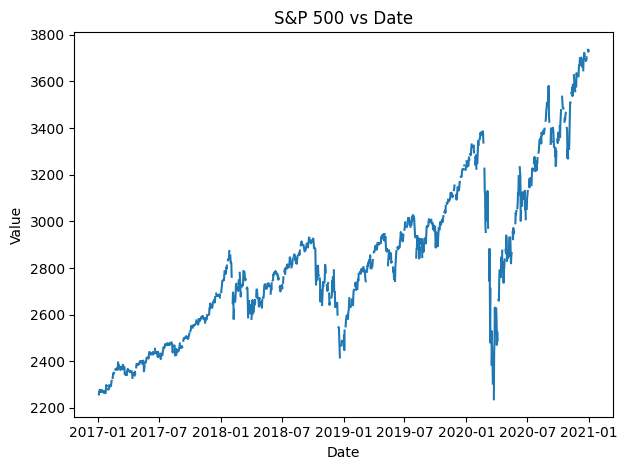

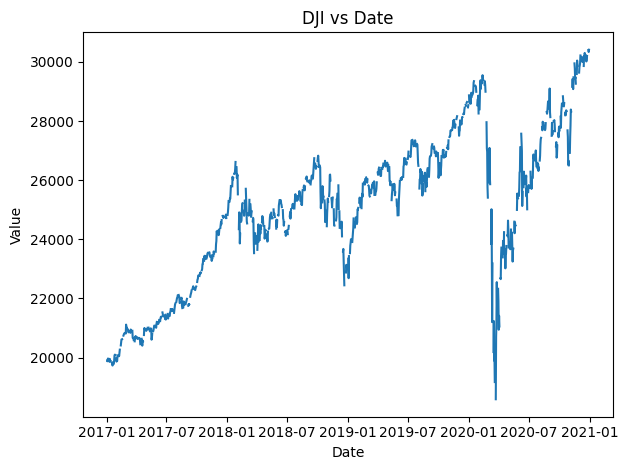

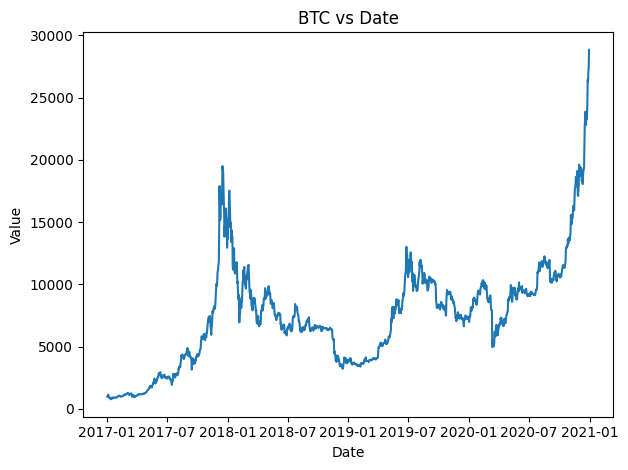

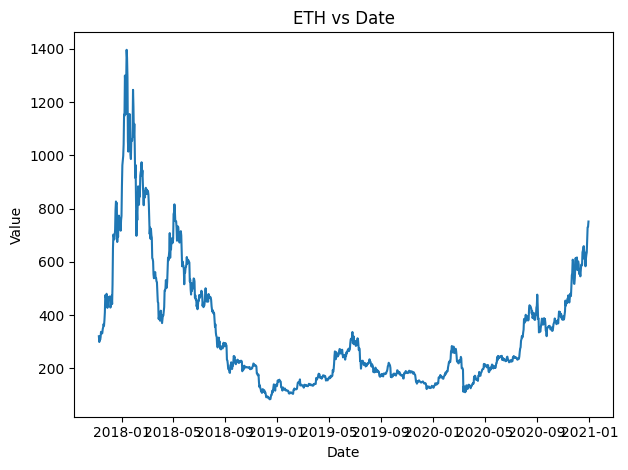

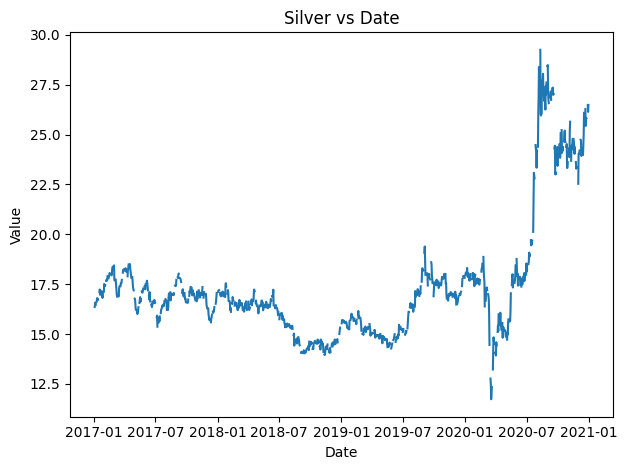

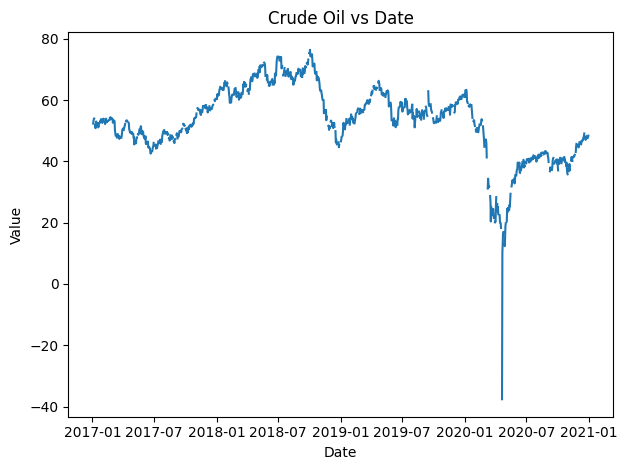

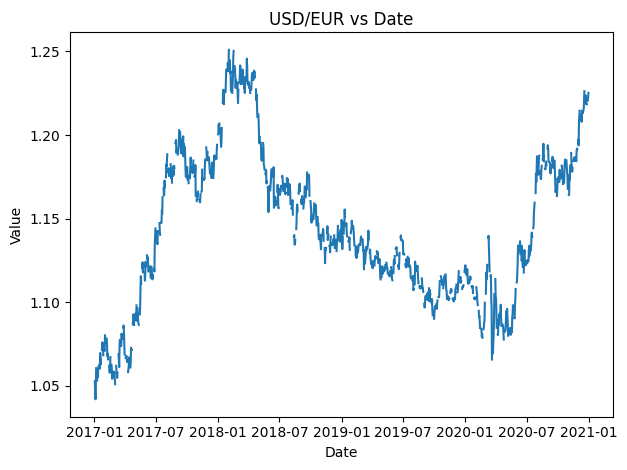

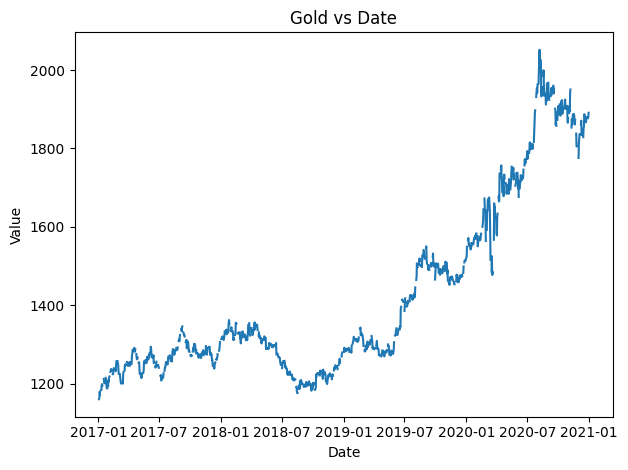

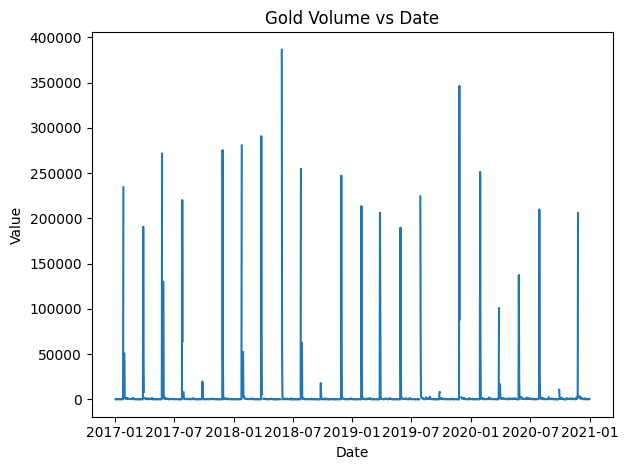

In [ ]:
import sys
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


start_date = "2017-01-01"
end_date = "2020-12-31"

feature_to_symbol = {
    "S&P 500": ("^GSPC", "Close"),
    "DJI": ("^DJI", "Close"),
    "BTC": ("BTC-USD", "Close"),
    "ETH": ("ETH-USD", "Close"),
    "Silver": ("SI=F", "Close"),
    "Crude Oil": ("CL=F", "Close"),
    "USD/EUR": ("EURUSD=X", "Close"),
    "Gold": ("GC=F", "Close"),
    "Gold Volume": ("GC=F", "Volume"),
}

symbols = sorted(set(sym for sym, _ in feature_to_symbol.values()))
raw = yf.download(
    tickers=symbols,
    start=start_date,
    end=end_date,
    interval="1d",
    group_by="ticker",
    auto_adjust=False,
    actions=False,
    progress=False,
)

series_map = {}
for feat, (sym, col) in feature_to_symbol.items():
    if isinstance(raw.columns, pd.MultiIndex):
        if sym in raw.columns.levels[0]:
            if col in raw[sym].columns:
                s = raw[sym][col]
            else:
                s = pd.Series(index=raw.index, dtype="float64")
        else:
            s = pd.Series(index=raw.index, dtype="float64")
    else:
        s = raw[col] if col in raw.columns else pd.Series(index=raw.index, dtype="float64")
    series_map[feat] = s.rename(feat)

features_df = pd.concat(series_map.values(), axis=1)
features_df = features_df.loc[start_date:end_date]

feature_dataframes = {}
for name in feature_to_symbol.keys():
    df = features_df[[name]].copy()
    df = df.reset_index().rename(columns={"index": "Date", name: "Value", "Date": "Date"})
    feature_dataframes[name] = df

for name, df in feature_dataframes.items():
    print(name)
    print(df.head())

for name, df in feature_dataframes.items():
    plt.figure()
    plt.plot(df["Date"], df["Value"])
    plt.title(f"{name} vs Date")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()


ann1

/tmp/ipython-input-3233499361.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")


R2_train: 0.992942
R2_test: 0.977827
TEST_MAE: 13.550183
TEST_RMSE: 20.827361
TEST_MAPE: 0.007715


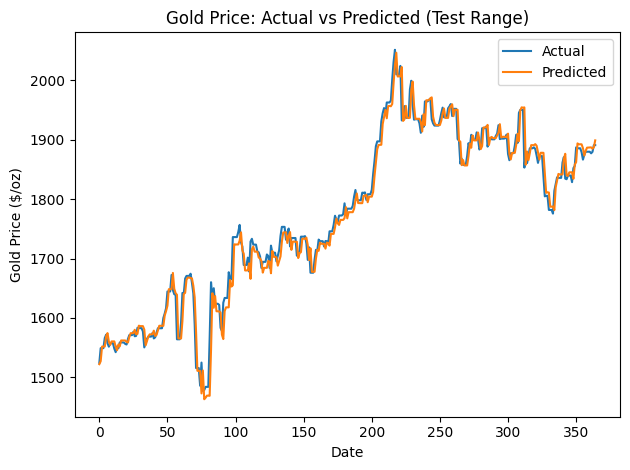

In [ ]:
import pandas as pd, numpy as np, tensorflow as tf, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = features_df.copy().sort_index()
y_next = df["Gold"].shift(-1)
data = pd.concat([df, y_next.rename("Gold_t_plus_1")], axis=1)
data = data.fillna(method="ffill").fillna(method="bfill")
n = len(data)
n_train = int(np.floor(0.75 * n))

X_train_raw = data.drop(columns=["Gold_t_plus_1"]).iloc[:n_train]
X_test_raw = data.drop(columns=["Gold_t_plus_1"]).iloc[n_train:]
y_train_raw = data[["Gold_t_plus_1"]].iloc[:n_train]
y_test_raw = data[["Gold_t_plus_1"]].iloc[n_train:]


scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train_raw.values)
X_test = scaler_X.transform(X_test_raw.values)
y_train = scaler_y.fit_transform(y_train_raw.values)
y_test = scaler_y.transform(y_test_raw.values)

tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(8, activation="relu"),
    tf.keras.layers.Dense(1, activation="linear")
])
model.compile(optimizer="adam", loss="mape")
model.fit(X_train, y_train, epochs=380, batch_size=10, verbose=0)

y_pred_train_scaled = model.predict(X_train, verbose=0)
y_pred_test_scaled = model.predict(X_test, verbose=0)

y_train_true = scaler_y.inverse_transform(y_train)
y_test_true = scaler_y.inverse_transform(y_test)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled)

r2_train = r2_score(y_train_true, y_pred_train)
r2_test = r2_score(y_test_true, y_pred_test)
mae_test = mean_absolute_error(y_test_true, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test_true, y_pred_test))
mape_test = np.mean(np.abs((y_test_true - y_pred_test) / y_test_true))

print(f"R2_train: {r2_train:.6f}")
print(f"R2_test: {r2_test:.6f}")
print(f"TEST_MAE: {mae_test:.6f}")
print(f"TEST_RMSE: {rmse_test:.6f}")
print(f"TEST_MAPE: {mape_test:.6f}")

plt.figure()
plt.plot(range(len(y_test_true)), y_test_true.ravel(), label="Actual")
plt.plot(range(len(y_pred_test)), y_pred_test.ravel(), label="Predicted")
plt.title("Gold Price: Actual vs Predicted (Test Range)")
plt.xlabel("Date")
plt.ylabel("Gold Price ($/oz)")
plt.legend()
plt.tight_layout()
plt.show()

svr1

R2_train: 0.973017
R2_test: 0.911569
TEST_MAE: 33.843636
TEST_RMSE: 41.593500
TEST_MAPE: 0.019180


/tmp/ipython-input-1437987654.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method="ffill").fillna(method="bfill")


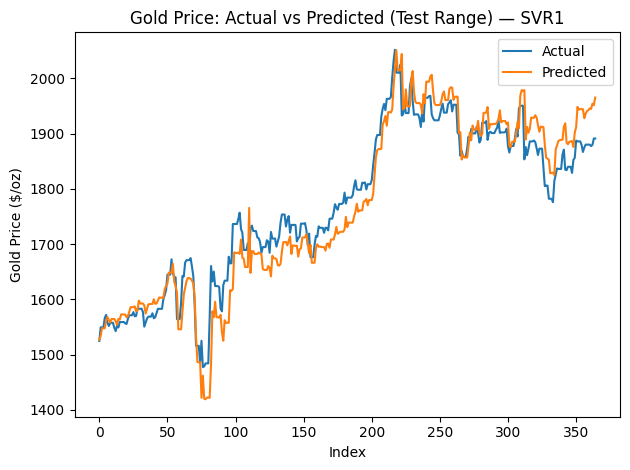

In [ ]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = features_df.copy().sort_index()
y_next = df["Gold"].shift(-1)
data = pd.concat([df, y_next.rename("Gold_t_plus_1")], axis=1)
data = data.fillna(method="ffill").fillna(method="bfill")
n = len(data)
n_train = int(np.floor(0.75 * n))

X_train_raw = data.drop(columns=["Gold_t_plus_1"]).iloc[:n_train]
X_test_raw  = data.drop(columns=["Gold_t_plus_1"]).iloc[n_train:]
y_train_raw = data[["Gold_t_plus_1"]].iloc[:n_train]
y_test_raw  = data[["Gold_t_plus_1"]].iloc[n_train:]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train_raw.values)
X_test  = scaler_X.transform(X_test_raw.values)
y_train = scaler_y.fit_transform(y_train_raw.values).ravel()
y_test  = scaler_y.transform(y_test_raw.values).ravel()

model = SVR(kernel="linear", C=1000, epsilon=0.1)
model.fit(X_train, y_train)

y_pred_train_s = model.predict(X_train).reshape(-1,1)
y_pred_test_s  = model.predict(X_test).reshape(-1,1)

y_train_true = scaler_y.inverse_transform(y_train.reshape(-1,1)).ravel()
y_test_true  = scaler_y.inverse_transform(y_test.reshape(-1,1)).ravel()
y_pred_train = scaler_y.inverse_transform(y_pred_train_s).ravel()
y_pred_test  = scaler_y.inverse_transform(y_pred_test_s).ravel()

r2_train = r2_score(y_train_true, y_pred_train)
r2_test  = r2_score(y_test_true,  y_pred_test)
mae_test = mean_absolute_error(y_test_true, y_pred_test)
rmse_test= np.sqrt(mean_squared_error(y_test_true, y_pred_test))
mape_test= np.mean(np.abs((y_test_true - y_pred_test) / y_test_true))

print(f"R2_train: {r2_train:.6f}")
print(f"R2_test: {r2_test:.6f}")
print(f"TEST_MAE: {mae_test:.6f}")
print(f"TEST_RMSE: {rmse_test:.6f}")
print(f"TEST_MAPE: {mape_test:.6f}")

plt.figure()
plt.plot(range(len(y_test_true)), y_test_true, label="Actual")
plt.plot(range(len(y_pred_test)), y_pred_test, label="Predicted")
plt.title("Gold Price: Actual vs Predicted (Test Range) — SVR1")
plt.xlabel("Index")
plt.ylabel("Gold Price ($/oz)")
plt.legend()
plt.tight_layout()
plt.show()


#lookback = 1, wavelet = db1, level = 1

In [ ]:
!pip install yfinance

In [ ]:
# CELL 1 — DATA FETCH (run once)

import time, requests
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr

def fetch_gc(symbol: str, start: str, end: str) -> pd.DataFrame:
    """Try multiple Yahoo endpoints to fetch historical daily Close prices."""
    for fetcher in [
        lambda: yf.download(tickers=symbol, start=start, end=end, auto_adjust=True, threads=False)[["Close"]],
        lambda: yf.Ticker(symbol).history(start=start, end=end, interval="1d", auto_adjust=True)[["Close"]],
        lambda: pdr.get_data_yahoo(symbol, start=start, end=end)[["Close"]],
        lambda: pd.read_csv(
            requests.get(
                f"https://query1.finance.yahoo.com/v7/finance/download/{symbol}"
                f"?period1={int(time.mktime(pd.to_datetime(start).timetuple()))}"
                f"&period2={int(time.mktime(pd.to_datetime(end).timetuple()))}"
                f"&interval=1d&events=history"
            ).text,
            parse_dates=["Date"], index_col="Date"
        )[["Close"]],
    ]:
        try:
            df = fetcher()
            if not df.empty:
                return df.dropna()
        except Exception:
            pass
    raise RuntimeError(f"All fetch methods failed for {symbol}")

# ----------------------- main fetch -----------------------
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")

# Gold (target), Oil (WTI), USD Index (DXY)
gold_df = fetch_gc("GC=F", start_date, end_date).rename(columns={"Close": "Gold"})
oil_df  = fetch_gc("CL=F", start_date, end_date).rename(columns={"Close": "Oil"})
usd_df  = fetch_gc("DX-Y.NYB", start_date, end_date).rename(columns={"Close": "USD_Index"})

# Merge aligned on dates
df = gold_df.join([oil_df, usd_df], how="inner").dropna()
print("Fetched data shape:", df.shape)
df.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Fetched data shape: (3986, 3)


Price,Gold,Oil,USD_Index
Ticker,GC=F,CL=F,DX-Y.NYB
Date,,,
2010-01-04,1117.699951,81.510002,77.529999
2010-01-05,1118.099976,81.769997,77.620003
2010-01-06,1135.900024,83.180000,77.489998
2010-01-07,1133.099976,82.660004,77.910004
2010-01-08,1138.199951,82.750000,77.470001


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 - 5s - 139ms/step - loss: 0.0114 - val_loss: 0.0138
Epoch 2/50
33/33 - 0s - 10ms/step - loss: 0.0129 - val_loss: 0.0128
Epoch 3/50
33/33 - 0s - 11ms/step - loss: 0.0112 - val_loss: 0.0129
Epoch 4/50
33/33 - 0s - 10ms/step - loss: 0.0112 - val_loss: 0.0119
Epoch 5/50
33/33 - 0s - 10ms/step - loss: 0.0116 - val_loss: 0.0136
Epoch 6/50
33/33 - 0s - 11ms/step - loss: 0.0112 - val_loss: 0.0119
Epoch 7/50
33/33 - 0s - 10ms/step - loss: 0.0117 - val_loss: 0.0138
Epoch 8/50
33/33 - 0s - 10ms/step - loss: 0.0111 - val_loss: 0.0120
Epoch 9/50
33/33 - 0s - 10ms/step - loss: 0.0117 - val_loss: 0.0142
Epoch 10/50
33/33 - 0s - 10ms/step - loss: 0.0112 - val_loss: 0.0127
Epoch 11/50
33/33 - 0s - 10ms/step - loss: 0.0117 - val_loss: 0.0132
Epoch 12/50
33/33 - 0s - 11ms/step - loss: 0.0111 - val_loss: 0.0127
Epoch 13/50
33/33 - 0s - 11ms/step - loss: 0.0113 - val_loss: 0.0130
Epoch 14/50
33/33 - 0s - 10ms/step - loss: 0.0112 - val_loss: 0.0126
Epoch 15/50
33/33 - 0s - 11ms/step - loss: 0.0111 - v

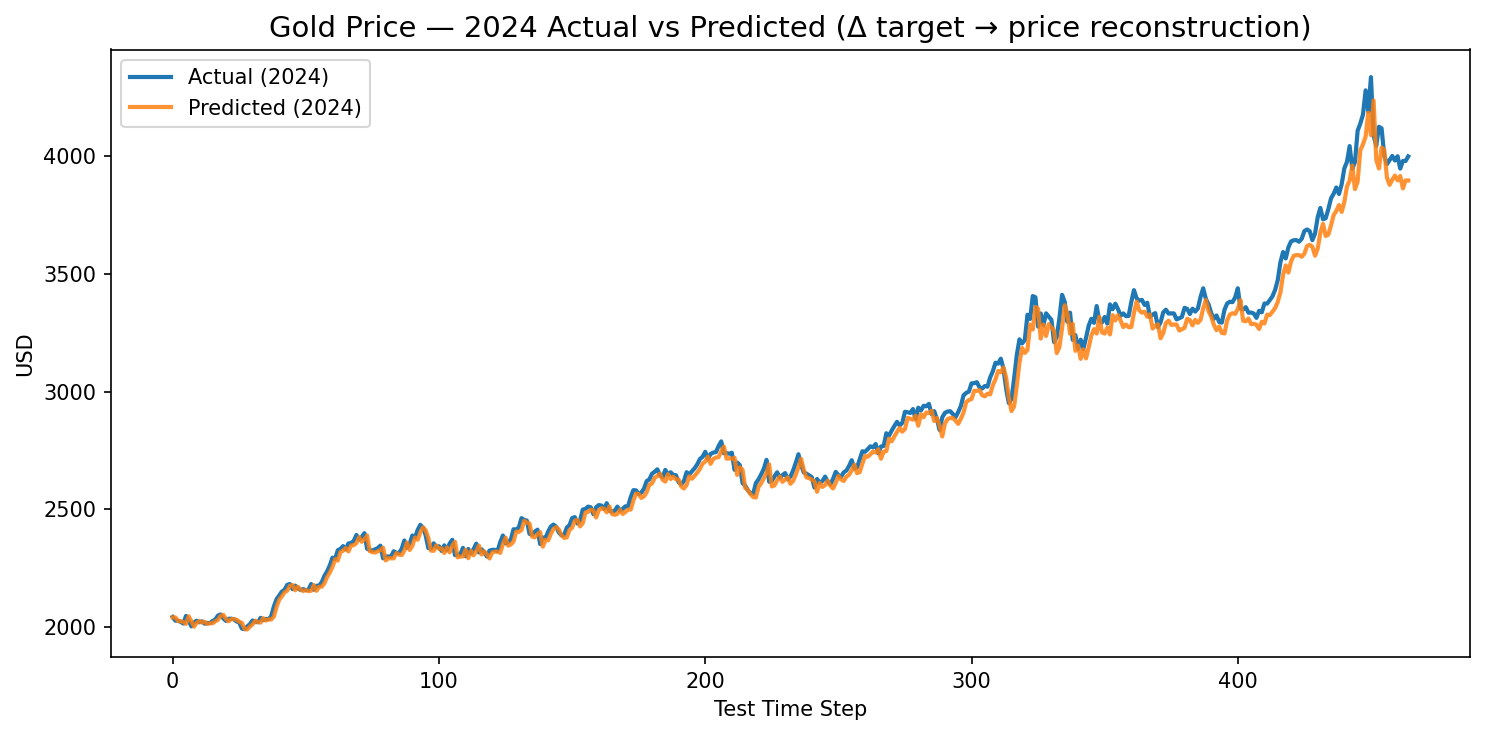

In [ ]:
# CELL 2 — SINGLE LSTM, DELTA TARGET, METRICS + PLOT

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ---------------- helpers ----------------
def build_sequences_delta(series_scaled, look_back=2):
    """
    Inputs: past 'look_back' scaled prices.
    Target: delta at t, i.e., y[t] - y[t-1] (on the same scaled space).
    Returns X, y_delta, base_scaled (y[t-1]) and true_next_scaled (y[t]).
    """
    X, y_delta, base, y_next = [], [], [], []
    for t in range(look_back+1, len(series_scaled)):
        window = series_scaled[t-look_back-1 : t-1]  # ends at y[t-1]
        X.append(window.reshape(-1, 1))
        y_delta.append(series_scaled[t] - series_scaled[t-1])   # Δ at t
        base.append(series_scaled[t-1])                         # y[t-1]
        y_next.append(series_scaled[t])                          # y[t]
    return np.array(X), np.array(y_delta), np.array(base), np.array(y_next)

def build_lstm(input_steps):
    m = Sequential([LSTM(128, input_shape=(input_steps, 1)), Dense(1)])
    m.compile(optimizer="adam", loss="mae")
    return m

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return rmse, mae, mape, r2

# ---------------- split ----------------
train_df = df.loc[:'2022-12-31'].copy()
val_df   = df.loc['2023-01-01':'2023-12-31'].copy()
test_df  = df.loc['2024-01-01':].copy()

# ---------------- scaling (fit on TRAIN only) ----------------
scaler = MinMaxScaler((0, 1))
train_scaled = scaler.fit_transform(train_df[["Close"]]).ravel()
val_scaled   = scaler.transform(val_df[["Close"]]).ravel()
test_scaled  = scaler.transform(test_df[["Close"]]).ravel()

# ---------------- sequences (Δ target) ----------------
look_back = 2
X_tr, d_tr, base_tr, y_tr_next = build_sequences_delta(train_scaled, look_back)
X_va, d_va, base_va, y_va_next = build_sequences_delta(val_scaled,   look_back)
X_te, d_te, base_te, y_te_next = build_sequences_delta(test_scaled,  look_back)

# ---------------- model ----------------
model = build_lstm(look_back)
model.fit(
    X_tr, d_tr,
    epochs=50, batch_size=100, shuffle=False,
    validation_data=(X_va, d_va), verbose=2
)

# ---------------- predictions → reconstruct price ----------------
pred_d_tr = model.predict(X_tr, verbose=0).ravel()
pred_d_te = model.predict(X_te, verbose=0).ravel()

pred_tr_scaled = base_tr + pred_d_tr           # ŷ_t (scaled)
pred_te_scaled = base_te + pred_d_te

true_tr_scaled = y_tr_next                      # y_t (scaled)
true_te_scaled = y_te_next

# back to USD
pred_tr = scaler.inverse_transform(pred_tr_scaled.reshape(-1,1)).ravel()
true_tr = scaler.inverse_transform(true_tr_scaled.reshape(-1,1)).ravel()

pred_te = scaler.inverse_transform(pred_te_scaled.reshape(-1,1)).ravel()
true_te = scaler.inverse_transform(true_te_scaled.reshape(-1,1)).ravel()

# ---------------- metrics table ----------------
rmse_tr, mae_tr, mape_tr, r2_tr = metrics(true_tr, pred_tr)
rmse_te, mae_te, mape_te, r2_te = metrics(true_te, pred_te)

summary = pd.DataFrame({
    "Split": ["Train", "Test (2024)"],
    "RMSE_USD": [rmse_tr, rmse_te],
    "MAE_USD":  [mae_tr,  mae_te],
    "MAPE_%":   [mape_tr, mape_te],
    "R2":       [r2_tr,   r2_te],
})
print("\n=== LSTM (Δ target) — Price Reconstruction Metrics ===")
print(summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# ---------------- plot: 2024 actual vs predicted ----------------
plt.figure(figsize=(10,5), dpi=150)
plt.plot(true_te, label="Actual (2024)", linewidth=2)
plt.plot(pred_te, label="Predicted (2024)", linewidth=2, alpha=0.85)
plt.title("Gold Price — 2024 Actual vs Predicted (Δ target → price reconstruction)", fontsize=14)
plt.xlabel("Test Time Step")
plt.ylabel("USD")
plt.legend()
plt.tight_layout(); plt.show()


new with more features

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 - 3s - 97ms/step - loss: 0.0205 - val_loss: 0.0193
Epoch 2/50
33/33 - 1s - 25ms/step - loss: 0.0200 - val_loss: 0.0457
Epoch 3/50
33/33 - 1s - 23ms/step - loss: 0.0216 - val_loss: 0.0529
Epoch 4/50
33/33 - 1s - 38ms/step - loss: 0.0206 - val_loss: 0.0120
Epoch 5/50
33/33 - 1s - 39ms/step - loss: 0.0184 - val_loss: 0.0242
Epoch 6/50
33/33 - 1s - 24ms/step - loss: 0.0133 - val_loss: 0.0119
Epoch 7/50
33/33 - 1s - 24ms/step - loss: 0.0160 - val_loss: 0.0316
Epoch 8/50
33/33 - 1s - 24ms/step - loss: 0.0138 - val_loss: 0.0161
Epoch 9/50
33/33 - 1s - 25ms/step - loss: 0.0170 - val_loss: 0.0198
Epoch 10/50
33/33 - 2s - 55ms/step - loss: 0.0114 - val_loss: 0.0134
Epoch 11/50
33/33 - 2s - 59ms/step - loss: 0.0117 - val_loss: 0.0127
Epoch 12/50
33/33 - 1s - 23ms/step - loss: 0.0133 - val_loss: 0.0197
Epoch 13/50
33/33 - 1s - 24ms/step - loss: 0.0130 - val_loss: 0.0123
Epoch 14/50
33/33 - 1s - 24ms/step - loss: 0.0120 - val_loss: 0.0195
Epoch 15/50
33/33 - 1s - 25ms/step - loss: 0.0133 - va

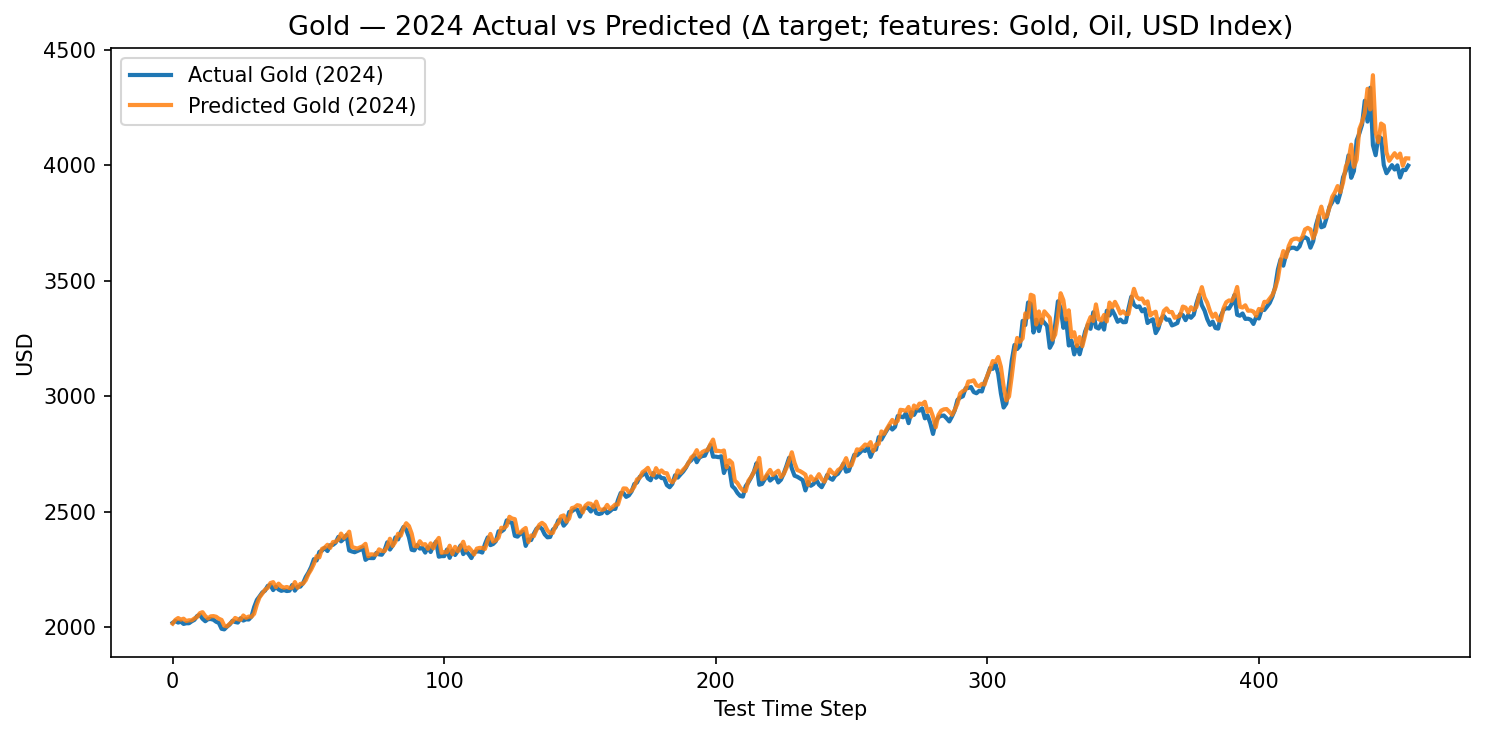

In [ ]:
# CELL 2 — SINGLE LSTM, Δ TARGET (Gold), MULTI-FEATURE INPUT (Gold, Oil, USD Index)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# ---------------- helpers ----------------
def build_sequences_delta_multifeat(feats_scaled, gold_scaled, look_back=10):
    """
    Inputs:
      feats_scaled: 2D array shape (T, F) with features [Gold, Oil, USD_Index] scaled on TRAIN-only stats.
      gold_scaled : 1D array shape (T,) with scaled Gold prices (same scaling as feats_scaled[:,0]).
    Target:
      delta at t: gold_scaled[t] - gold_scaled[t-1]  (same scaled space).
    Returns:
      X: (N, look_back, F), y_delta: (N,), base_scaled: y[t-1], y_next_scaled: y[t]
    """
    X, y_delta, base, y_next = [], [], [], []
    for t in range(look_back + 1, len(gold_scaled)):
        X.append(feats_scaled[t - look_back - 1 : t - 1, :])           # window ends at t-1
        y_delta.append(gold_scaled[t] - gold_scaled[t - 1])            # Δ at t
        base.append(gold_scaled[t - 1])                                 # y[t-1]
        y_next.append(gold_scaled[t])                                    # y[t]
    return np.array(X), np.array(y_delta), np.array(base), np.array(y_next)

def build_lstm(input_steps, input_feats):
    m = Sequential([LSTM(128, input_shape=(input_steps, input_feats)), Dense(1)])
    m.compile(optimizer="adam", loss="mae")
    return m

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return rmse, mae, mape, r2

# ---------------- split ----------------
# df must come from CELL 1 and contain columns: ["Gold", "Oil", "USD_Index"]
train_df = df.loc[:'2022-12-31'].copy()
val_df   = df.loc['2023-01-01':'2023-12-31'].copy()
test_df  = df.loc['2024-01-01':].copy()

# ---------------- scaling (fit on TRAIN only; columnwise) ----------------
feat_scaler = MinMaxScaler((0, 1))
train_feats = feat_scaler.fit_transform(train_df[["Gold", "Oil", "USD_Index"]].values)
val_feats   = feat_scaler.transform   (val_df  [["Gold", "Oil", "USD_Index"]].values)
test_feats  = feat_scaler.transform   (test_df [["Gold", "Oil", "USD_Index"]].values)

# The first column in feats is Gold; keep a dedicated price scaler for inverse transform to USD
price_scaler = MinMaxScaler((0, 1))
train_gold_scaled = price_scaler.fit_transform(train_df[["Gold"]]).ravel()
val_gold_scaled   = price_scaler.transform   (val_df[["Gold"]]).ravel()
test_gold_scaled  = price_scaler.transform   (test_df[["Gold"]]).ravel()

# ---------------- sequences (Δ target) ----------------
look_back = 10  # you can switch between 2/10/30 etc.
X_tr, d_tr, base_tr, y_tr_next = build_sequences_delta_multifeat(train_feats, train_gold_scaled, look_back)
X_va, d_va, base_va, y_va_next = build_sequences_delta_multifeat(val_feats,   val_gold_scaled,   look_back)
X_te, d_te, base_te, y_te_next = build_sequences_delta_multifeat(test_feats,  test_gold_scaled,  look_back)

# ---------------- model ----------------
n_feats = X_tr.shape[2]
model = build_lstm(look_back, n_feats)
model.fit(X_tr, d_tr, epochs=50, batch_size=100, shuffle=False,
          validation_data=(X_va, d_va), verbose=2)

# ---------------- predictions → reconstruct Gold price ----------------
pred_d_tr = model.predict(X_tr, verbose=0).ravel()
pred_d_te = model.predict(X_te, verbose=0).ravel()

pred_tr_scaled = base_tr + pred_d_tr
pred_te_scaled = base_te + pred_d_te

true_tr_scaled = y_tr_next
true_te_scaled = y_te_next

# back to USD
pred_tr = price_scaler.inverse_transform(pred_tr_scaled.reshape(-1,1)).ravel()
true_tr = price_scaler.inverse_transform(true_tr_scaled.reshape(-1,1)).ravel()
pred_te = price_scaler.inverse_transform(pred_te_scaled.reshape(-1,1)).ravel()
true_te = price_scaler.inverse_transform(true_te_scaled.reshape(-1,1)).ravel()

# ---------------- metrics table ----------------
rmse_tr, mae_tr, mape_tr, r2_tr = metrics(true_tr, pred_tr)
rmse_te, mae_te, mape_te, r2_te = metrics(true_te, pred_te)

summary = pd.DataFrame({
    "Split": ["Train", "Test (2024)"],
    "RMSE_USD": [rmse_tr, rmse_te],
    "MAE_USD":  [mae_tr,  mae_te],
    "MAPE_%":   [mape_tr, mape_te],
    "R2":       [r2_tr,   r2_te],
})
print("\n=== LSTM (Δ target, features: Gold/Oil/USD Index) — Price Reconstruction Metrics ===")
print(summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# ---------------- plot: 2024 actual vs predicted (Gold) ----------------
plt.figure(figsize=(10,5), dpi=150)
plt.plot(true_te, label="Actual Gold (2024)", linewidth=2)
plt.plot(pred_te, label="Predicted Gold (2024)", linewidth=2, alpha=0.85)
plt.title("Gold — 2024 Actual vs Predicted (Δ target; features: Gold, Oil, USD Index)", fontsize=13)
plt.xlabel("Test Time Step"); plt.ylabel("USD")
plt.legend()
plt.tight_layout(); plt.show()


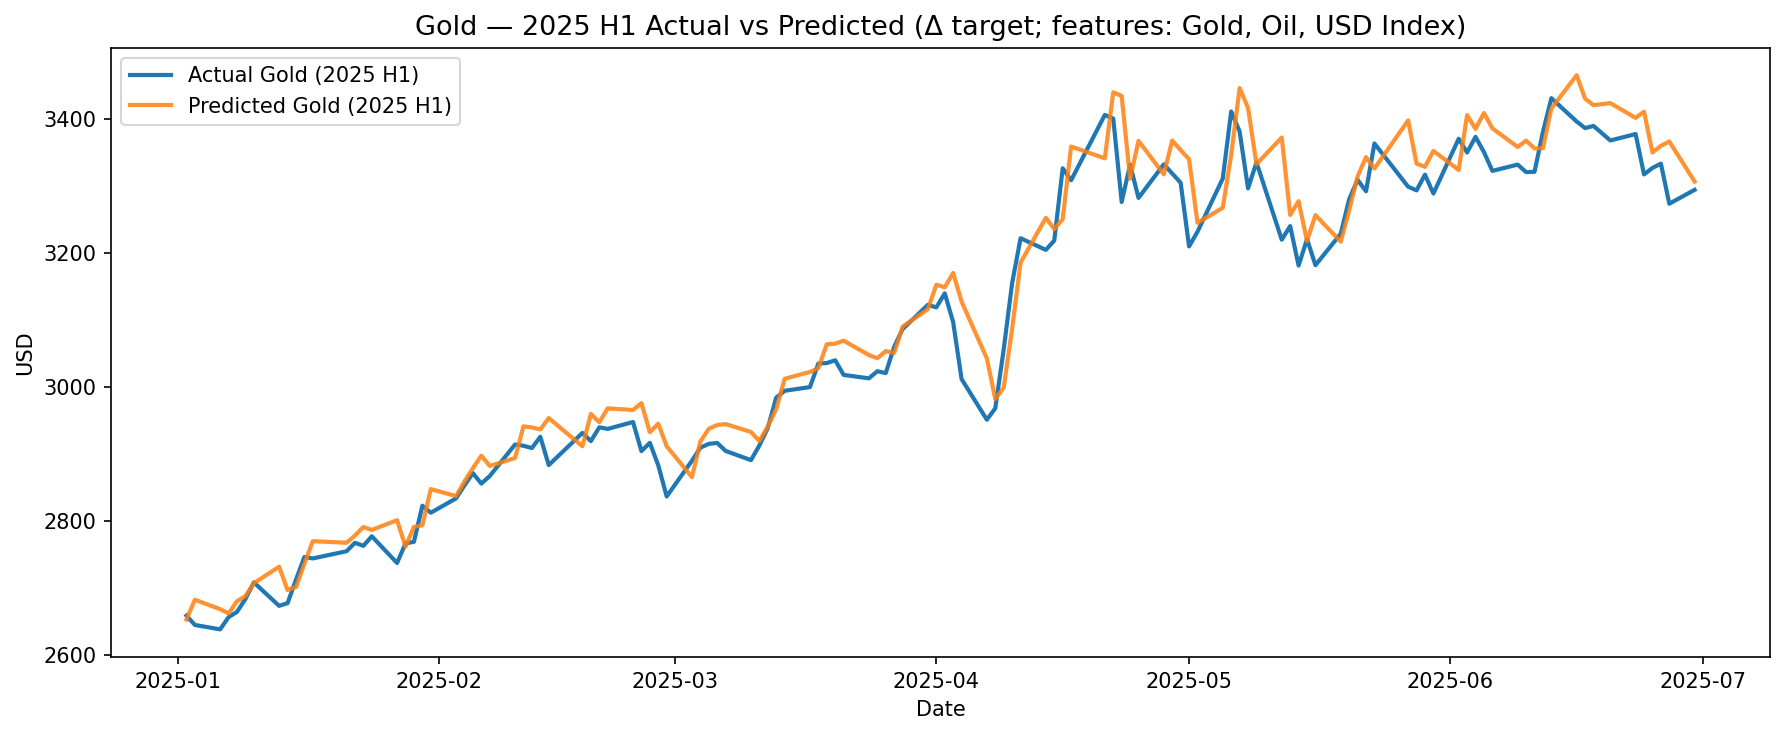

In [ ]:
# CELL — Predict & plot 2025 H1 using the already-trained model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- config for the window to visualize ----
start_h1 = pd.Timestamp("2025-01-01")
end_h1   = pd.Timestamp("2025-06-30")

# Sanity: ensure required objects exist
for name in ["df", "model", "feat_scaler", "price_scaler", "look_back"]:
    assert name in globals(), f"Missing variable: {name}"

# Scale the *entire* series using TRAIN-FIT scalers (do NOT refit!)
feats_all = feat_scaler.transform(df[["Gold","Oil","USD_Index"]].values)
gold_all  = price_scaler.transform(df[["Gold"]]).ravel()

# Build windows that end at t-1 and predict Δ at t for t in [start_h1..end_h1]
mask = (df.index >= start_h1) & (df.index <= end_h1)
t_indices = np.where(mask)[0]

X_h1, base_h1, true_h1 = [], [], []
dates_h1 = []

for t in t_indices:
    # need look_back+1 history to form a window ending at (t-1)
    if t - (look_back + 1) < 0:
        continue
    X_h1.append(feats_all[t - look_back - 1 : t - 1, :])  # (look_back, F)
    base_h1.append(gold_all[t - 1])                       # y[t-1] scaled
    true_h1.append(gold_all[t])                           # y[t]    scaled
    dates_h1.append(df.index[t])

if len(X_h1) == 0:
    raise RuntimeError("Not enough history to build windows for the requested date range.")

X_h1   = np.array(X_h1)
base_h1 = np.array(base_h1)
true_h1 = np.array(true_h1)

# Predict Δ, reconstruct price in scaled space
pred_d_h1 = model.predict(X_h1, verbose=0).ravel()
pred_h1_scaled = base_h1 + pred_d_h1
true_h1_scaled = true_h1

# Back to USD
pred_h1 = price_scaler.inverse_transform(pred_h1_scaled.reshape(-1,1)).ravel()
true_h1 = price_scaler.inverse_transform(true_h1_scaled.reshape(-1,1)).ravel()

# Plot
plt.figure(figsize=(12,5), dpi=150)
plt.plot(dates_h1, true_h1, label="Actual Gold (2025 H1)", linewidth=2)
plt.plot(dates_h1, pred_h1, label="Predicted Gold (2025 H1)", linewidth=2, alpha=0.85)
plt.title("Gold — 2025 H1 Actual vs Predicted (Δ target; features: Gold, Oil, USD Index)", fontsize=13)
plt.xlabel("Date"); plt.ylabel("USD")
plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
# CELL — 2025 H1 diagnostics: metrics, persistence baseline, lag

import numpy as np
import pandas as pd

def metrics(y_true, y_pred):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mae  = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan
    return rmse, mae, mape, r2

def best_lag(y_true, y_pred, max_lag=5):
    lags = range(-max_lag, max_lag + 1)
    corrs = []
    for k in lags:
        if k < 0:
            a = y_true[-k:]; b = y_pred[:len(y_pred)+k]
        elif k > 0:
            a = y_true[:-k]; b = y_pred[k:]
        else:
            a = y_true; b = y_pred
        corrs.append(np.corrcoef(a, b)[0,1])
    k_star = lags[int(np.nanargmax(corrs))]
    return k_star, np.nanmax(corrs)

# Model metrics
rmse_m, mae_m, mape_m, r2_m = metrics(true_h1, pred_h1)

# Persistence baseline on the same alignment (ŷ_t = y_{t-1})
y_true_shift = true_h1[1:]
y_persist    = true_h1[:-1]
rmse_p, mae_p, mape_p, r2_p = metrics(y_true_shift, y_persist)

# Lag check
k_star, corr_star = best_lag(true_h1, pred_h1, max_lag=5)

# Summary table
summary = pd.DataFrame([
    ["Model (2025 H1)", rmse_m, mae_m, mape_m, r2_m],
    ["Persistence (2025 H1)", rmse_p, mae_p, mape_p, r2_p]
], columns=["Series","RMSE_USD","MAE_USD","MAPE_%","R2"])

print(summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
print(f"\nLag check (2025 H1): best shift k = {k_star} days, corr = {corr_star:.4f} "
      "(k>0 means predictions lag the truth).")


               Series  RMSE_USD  MAE_USD  MAPE_%     R2
      Model (2025 H1)   49.0817  37.5049  1.2010 0.9566
Persistence (2025 H1)   42.1048  31.6107  1.0099 0.9675

Lag check (2025 H1): best shift k = 1 days, corr = 1.0000 (k>0 means predictions lag the truth).


In [ ]:
# CELL — Results Summary Across Look-Backs and Features

import pandas as pd

# manually fill from your LSTM logs
results = [
    # look_back, n_features, RMSE_Train, MAE_Train, MAPE_Train, R2_Train, RMSE_Test, MAE_Test, MAPE_Test, R2_Test
    [2,  1, 53.0372, 39.4432, 1.2911, 0.9908, 53.0372, 39.4432, 1.2911, 0.9908],
    [10, 1, 16.2771, 11.6889, 0.8104, 0.9957, 44.7808, 33.5293, 1.1171, 0.9933],
    [10, 3, 17.1351, 12.3583, 0.8517, 0.9953, 42.5524, 29.5718, 1.0043, 0.9940],
    # add more if you test other look-backs or features
]

summary_df = pd.DataFrame(
    results,
    columns=[
        "Look_Back", "n_Features",
        "RMSE_Train", "MAE_Train", "MAPE_Train", "R2_Train",
        "RMSE_Test", "MAE_Test", "MAPE_Test", "R2_Test"
    ]
)

print("\n=== LSTM Δ-Target Summary — Look-Back vs Features ===")
print(summary_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))



=== LSTM Δ-Target Summary — Look-Back vs Features ===
 Look_Back  n_Features  RMSE_Train  MAE_Train  MAPE_Train  R2_Train  RMSE_Test  MAE_Test  MAPE_Test  R2_Test
         2           1     53.0372    39.4432      1.2911    0.9908    53.0372   39.4432     1.2911   0.9908
        10           1     16.2771    11.6889      0.8104    0.9957    44.7808   33.5293     1.1171   0.9933
        10           3     17.1351    12.3583      0.8517    0.9953    42.5524   29.5718     1.0043   0.9940


old

In [ ]:
import time, requests
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

import yfinance as yf
from pandas_datareader import data as pdr

def fetch_gc(symbol, start, end):

    # 1) yfinance.download
    try:
        df = yf.download(
            tickers=symbol,
            start=start,
            end=end,
            auto_adjust=True,
            threads=False
        )[["Close"]]
        if not df.empty:
            print("Fetched with yf.download:", df.shape)
            print(df.head())
            return df.dropna()
    except Exception as e:
        print("download() failed:", e)


    try:
        df = yf.Ticker(symbol).history(
            start=start,
            end=end,
            interval="1d",
            auto_adjust=True
        )[["Close"]]
        if not df.empty:
            print("Fetched with Ticker.history:", df.shape)
            print(df.head())
            return df.dropna()
    except Exception as e:
        print("Ticker.history() failed:", e)

    #pandas_datareader
    try:
        df = pdr.get_data_yahoo(symbol, start=start, end=end)[["Close"]]
        if not df.empty:
            print("Fetched with pandas_datareader:", df.shape)
            print(df.head())
            return df.dropna()
    except Exception as e:
        print("pdr.get_data_yahoo() failed:", e)

    #direct CSV download
    try:
        period1 = int(time.mktime(pd.to_datetime(start).timetuple()))
        period2 = int(time.mktime(pd.to_datetime(end).timetuple()))
        url = (
            f"https://query1.finance.yahoo.com/v7/finance/download/{symbol}"
            f"?period1={period1}&period2={period2}"
            "&interval=1d&events=history"
        )
        r = requests.get(url)
        r.raise_for_status()
        df = pd.read_csv(
            pd.compat.StringIO(r.text),
            parse_dates=["Date"], index_col="Date"
        )[["Close"]]
        if not df.empty:
            print("Fetched with direct CSV URL:", df.shape)
            print(df.head())
            return df.dropna()
    except Exception as e:
        print("CSV-download failed:", e)

    raise RuntimeError(f"All fetch methods failed for {symbol}")

# ──────────────────────────────────────────────────────────────────────────────

start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = fetch_gc("GC=F", start_date, end_date)

# Split
train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]

val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]
print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Scale
scaler        = MinMaxScaler((0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])



# Trim to even length for SWT
def trim_for_swt(arr, df_ref, div):
    """Trim the last few samples so len(arr) % div == 0."""
    rem = arr.shape[0] % div
    if rem > 0:  # Only trim if needed
        arr = arr[:-rem]
        df_ref.drop(df_ref.tail(rem).index, inplace=True)
    return arr, df_ref
##########################################################3
wavelet = 'db1'
level   = 1
div = 2**level

train_scaled, train_df = trim_for_swt(train_scaled, train_df, div)
val_scaled,   val_df   = trim_for_swt(val_scaled,   val_df, div)
test_scaled,  test_df  = trim_for_swt(test_scaled,  test_df, div)
print("Trimmed lengths →",
      len(train_scaled), len(val_scaled), len(test_scaled))



# SWT level-1
coeffs_train = pywt.swt(train_scaled[:,0], wavelet, level=level)
coeffs_val   = pywt.swt(val_scaled[:,0],   wavelet, level=level)
coeffs_test  = pywt.swt(test_scaled[:,0],  wavelet, level=level)

cA_train = coeffs_train[-1][0]
cA_val   = coeffs_val[-1][0]
cA_test  = coeffs_test[-1][0]

cD_train = coeffs_train[0][1]
cD_val   = coeffs_val[0][1]
cD_test  = coeffs_test[0][1]

###########################################################3
def make_sequences(data, look_back=1):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 1
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)

# Reshape for LSTM
def to_lstm_shape(X):
    return X.reshape(-1, look_back, 1)

X_A_train, X_A_val, X_A_test = map(to_lstm_shape, (X_A_train, X_A_val, X_A_test))
X_D_train, X_D_val, X_D_test = map(to_lstm_shape, (X_D_train, X_D_val, X_D_test))

# Build model
def build_lstm():
    model = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return model

model_A = build_lstm()
model_D = build_lstm()

# Train
model_A.fit(X_A_train, y_A_train,
            epochs=150, batch_size=100,
            shuffle=False,
            validation_data=(X_A_val, y_A_val),
            verbose=2)

model_D.fit(X_D_train, y_D_train,
            epochs=150, batch_size=100,
            shuffle=False,
            validation_data=(X_D_val, y_D_val),
            verbose=2)

# Predict + invert scale
pred_A       = model_A.predict(X_A_test).flatten()
pred_D       = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D
truetarget = y_A_test.reshape(-1,1) + y_D_test.reshape(-1,1)
combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(truetarget.reshape(-1,1))

[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-77698021.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ref.drop(df_ref.tail(rem).index, inplace=True)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fetched with yf.download: (3984, 1)
Price             Close
Ticker             GC=F
Date                   
2010-01-04  1117.699951
2010-01-05  1118.099976
2010-01-06  1135.900024
2010-01-07  1133.099976
2010-01-08  1138.199951
Rows → Train: 2779, Val: 490, Test: 715
Trimmed lengths → 2778 490 714
Epoch 1/150
28/28 - 3s - 116ms/step - loss: 81.6274 - val_loss: 77.9986
Epoch 2/150
28/28 - 0s - 7ms/step - loss: 53.5611 - val_loss: 56.8064
Epoch 3/150
28/28 - 0s - 7ms/step - loss: 42.4964 - val_loss: 43.8318
Epoch 4/150
28/28 - 0s - 7ms/step - loss: 37.2961 - val_loss: 35.9141
Epoch 5/150
28/28 - 0s - 7ms/step - loss: 31.4473 - val_loss: 28.0741
Epoch 6/150
28/28 - 0s - 8ms/step - loss: 25.1529 - val_loss: 19.1341
Epoch 7/150
28/28 - 0s - 7ms/step - loss: 18.3057 - val_loss: 9.4534
Epoch 8/150
28/28 - 0s - 7ms/step - loss: 11.0677 - val_loss: 1.5737
Epoch 9/150
28/28 - 0s - 7ms/step - loss: 5.9420 - val_loss: 7.1451
Epoch 10/150
28/28 - 0s - 7ms/step - loss: 5.3227 - val_loss: 7.2251
Epoc

Test MAPE: 4.34%


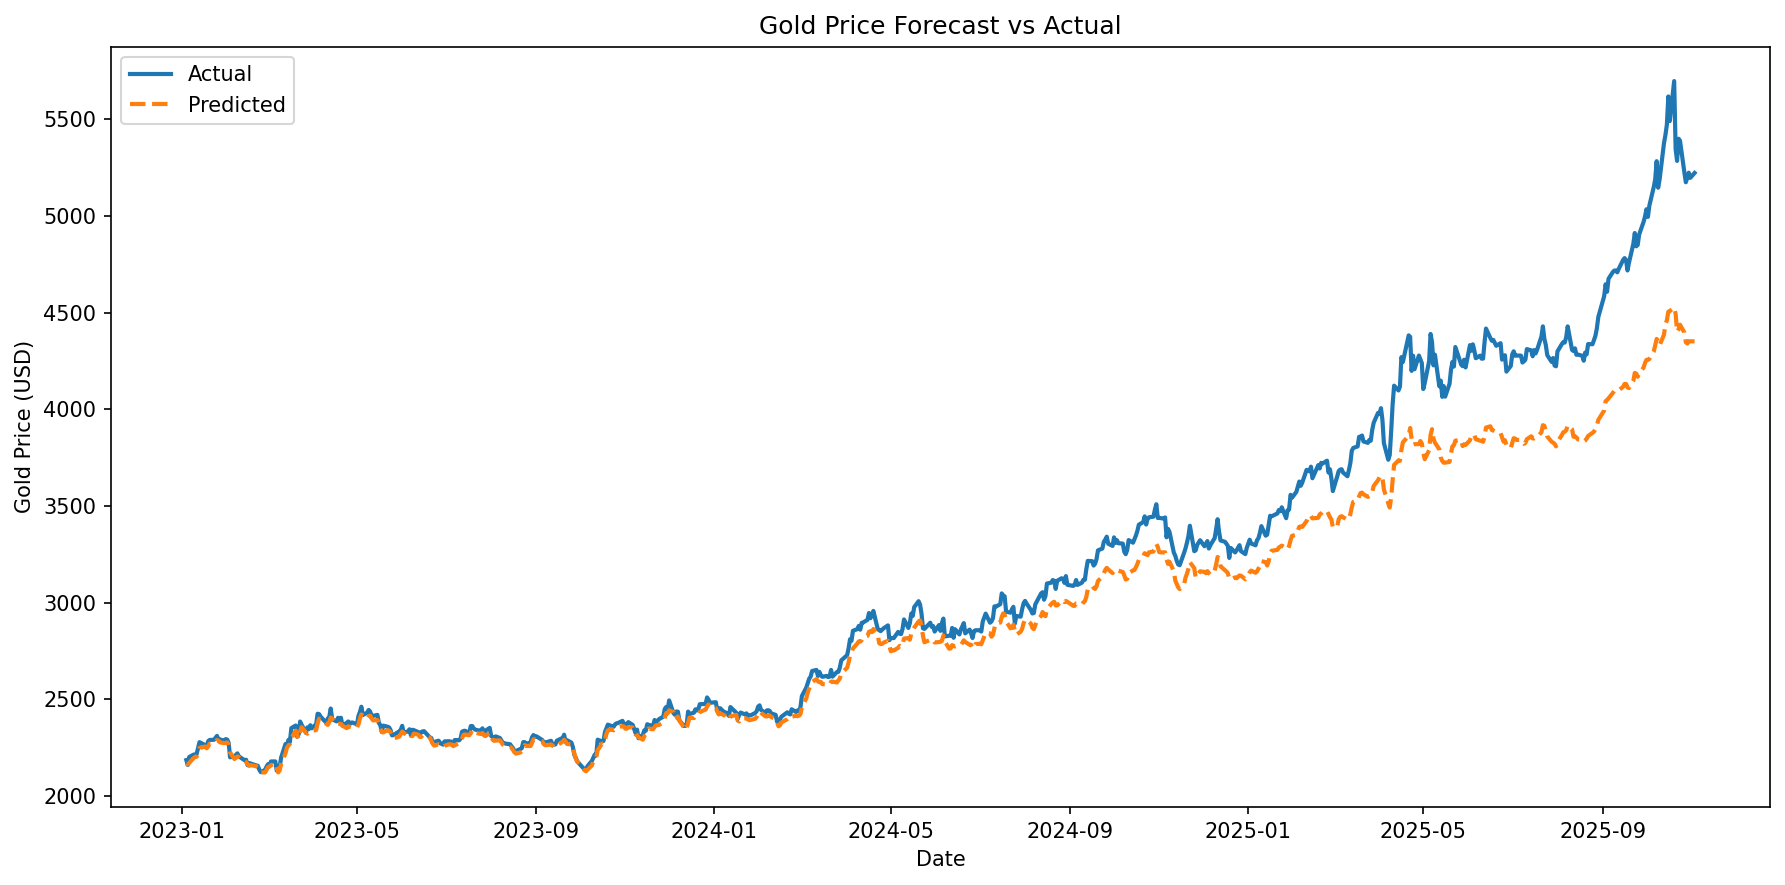

RMSE: 276.85 USD
MAE:  171.78 USD
MAPE: 4.34%
RSE:  277.23 USD
R²:   0.8951


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)


n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))
print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")


#lookback = 10, wavelet = db1, level = 1

In [ ]:
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import yfinance as yf
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()


train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]


val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]

print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

scaler      = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])

#If lengths are odd, trim last row for SWT
if train_scaled.shape[0] % 2 != 0:
    train_scaled = train_scaled[:-1]
    train_df = train_df.iloc[:-1]
if val_scaled.shape[0] % 2 != 0:
    val_scaled = val_scaled[:-1]
    val_df = val_df.iloc[:-1]
if test_scaled.shape[0] % 2 != 0:
    test_scaled = test_scaled[:-1]
    test_df = test_df.iloc[:-1]



cA_train, cD_train = pywt.swt(train_scaled[:,0], 'db1', level=1)[0]
cA_val,   cD_val   = pywt.swt(val_scaled[:,0],   'db1', level=1)[0]
cA_test,  cD_test  = pywt.swt(test_scaled[:,0],  'db1', level=1)[0]


def make_sequences(data, look_back=10):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 10
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)


X_A_train = X_A_train.reshape(-1, look_back, 1)
X_A_val   = X_A_val.reshape(-1, look_back, 1)
X_A_test  = X_A_test.reshape(-1, look_back, 1)
X_D_train = X_D_train.reshape(-1, look_back, 1)
X_D_val   = X_D_val.reshape(-1, look_back, 1)
X_D_test  = X_D_test.reshape(-1, look_back, 1)


def build_lstm_model():
    m = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return m

model_A = build_lstm_model()
model_D = build_lstm_model()


history_A = model_A.fit(
    X_A_train, y_A_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_A_val, y_A_val),
    verbose=2
)
history_D = model_D.fit(
    X_D_train, y_D_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_D_val, y_D_val),
    verbose=2
)


pred_A = model_A.predict(X_A_test).flatten()
pred_D = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D
truetarget = y_A_test.reshape(-1,1) + y_D_test.reshape(-1,1)
combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(truetarget.reshape(-1,1))

/tmp/ipython-input-465095929.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Rows → Train: 2779, Val: 490, Test: 715
Epoch 1/150
28/28 - 3s - 106ms/step - loss: 40.4063 - val_loss: 6.8799
Epoch 2/150
28/28 - 1s - 18ms/step - loss: 12.2464 - val_loss: 5.9493
Epoch 3/150
28/28 - 1s - 20ms/step - loss: 10.4561 - val_loss: 4.1660
Epoch 4/150
28/28 - 1s - 19ms/step - loss: 8.6797 - val_loss: 3.1184
Epoch 5/150
28/28 - 1s - 20ms/step - loss: 8.4270 - val_loss: 3.1627
Epoch 6/150
28/28 - 1s - 19ms/step - loss: 8.7715 - val_loss: 2.9764
Epoch 7/150
28/28 - 1s - 19ms/step - loss: 8.3798 - val_loss: 3.0533
Epoch 8/150
28/28 - 1s - 19ms/step - loss: 8.0085 - val_loss: 2.6828
Epoch 9/150
28/28 - 1s - 22ms/step - loss: 7.8132 - val_loss: 3.8533
Epoch 10/150
28/28 - 1s - 19ms/step - loss: 9.0452 - val_loss: 3.2043
Epoch 11/150
28/28 - 1s - 18ms/step - loss: 8.3297 - val_loss: 3.5080
Epoch 12/150
28/28 - 1s - 19ms/step - loss: 8.7853 - val_loss: 3.0338
Epoch 13/150
28/28 - 1s - 19ms/step - loss: 8.0234 - val_loss: 2.5009
Epoch 14/150
28/28 - 1s - 21ms/step - loss: 7.1554 - va

Test MAPE: 3.78%


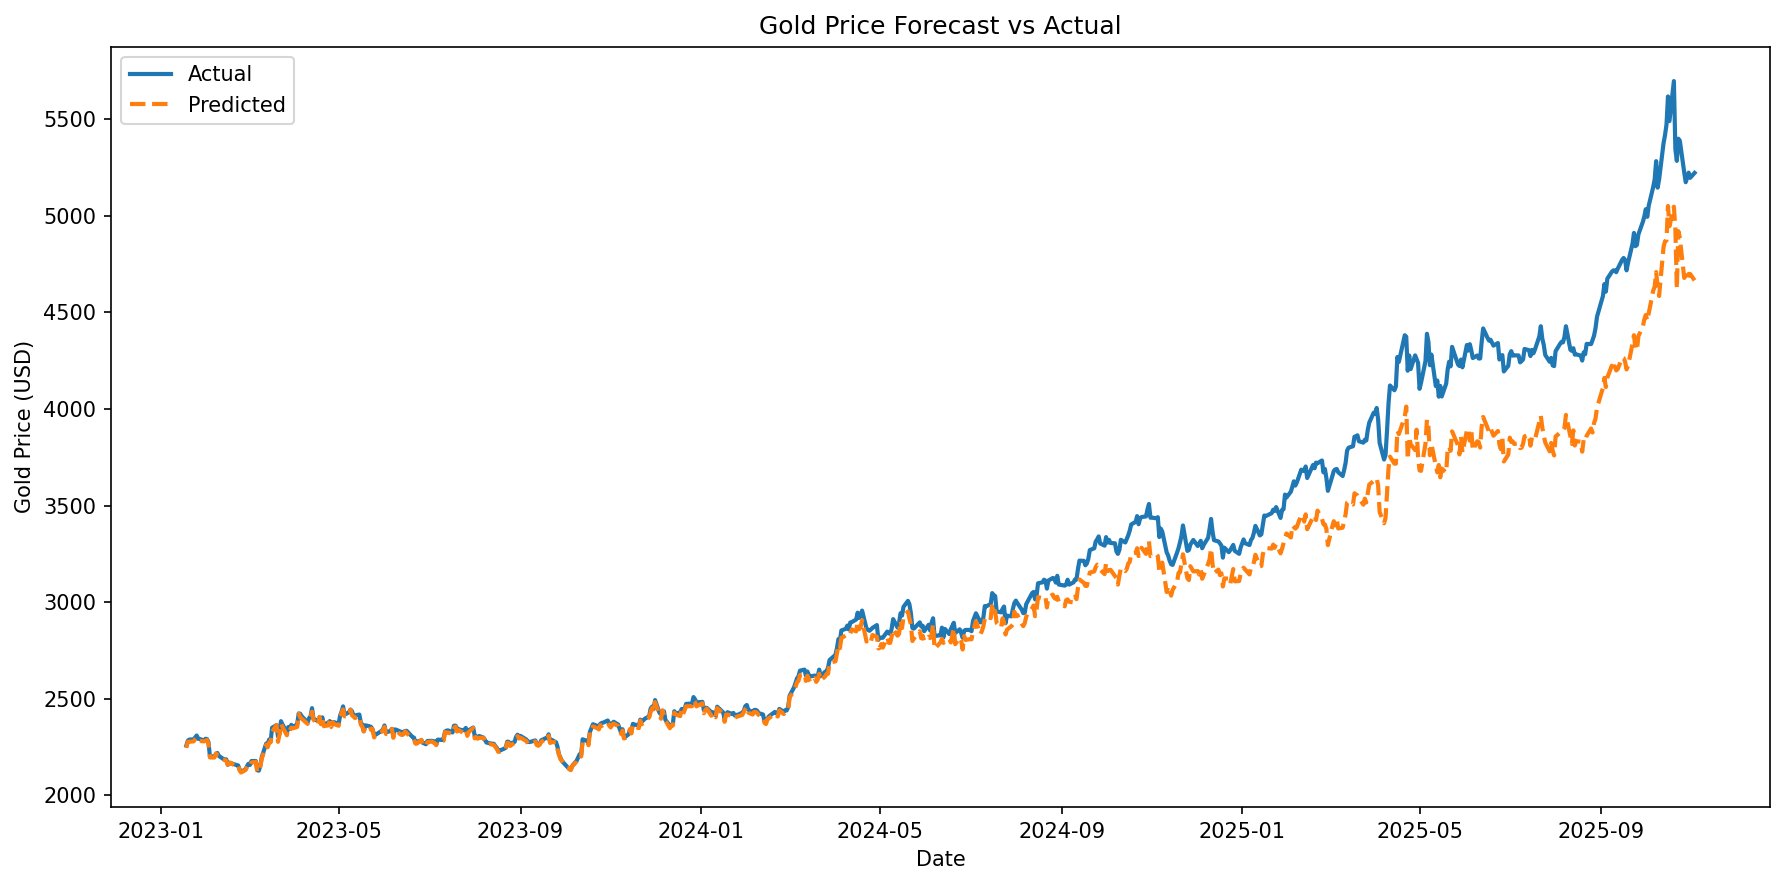

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")


plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()


rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)

n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")


RMSE: 235.48 USD
MAE:  150.46 USD
MAPE: 3.78%
RSE:  235.82 USD
R²:   0.9240


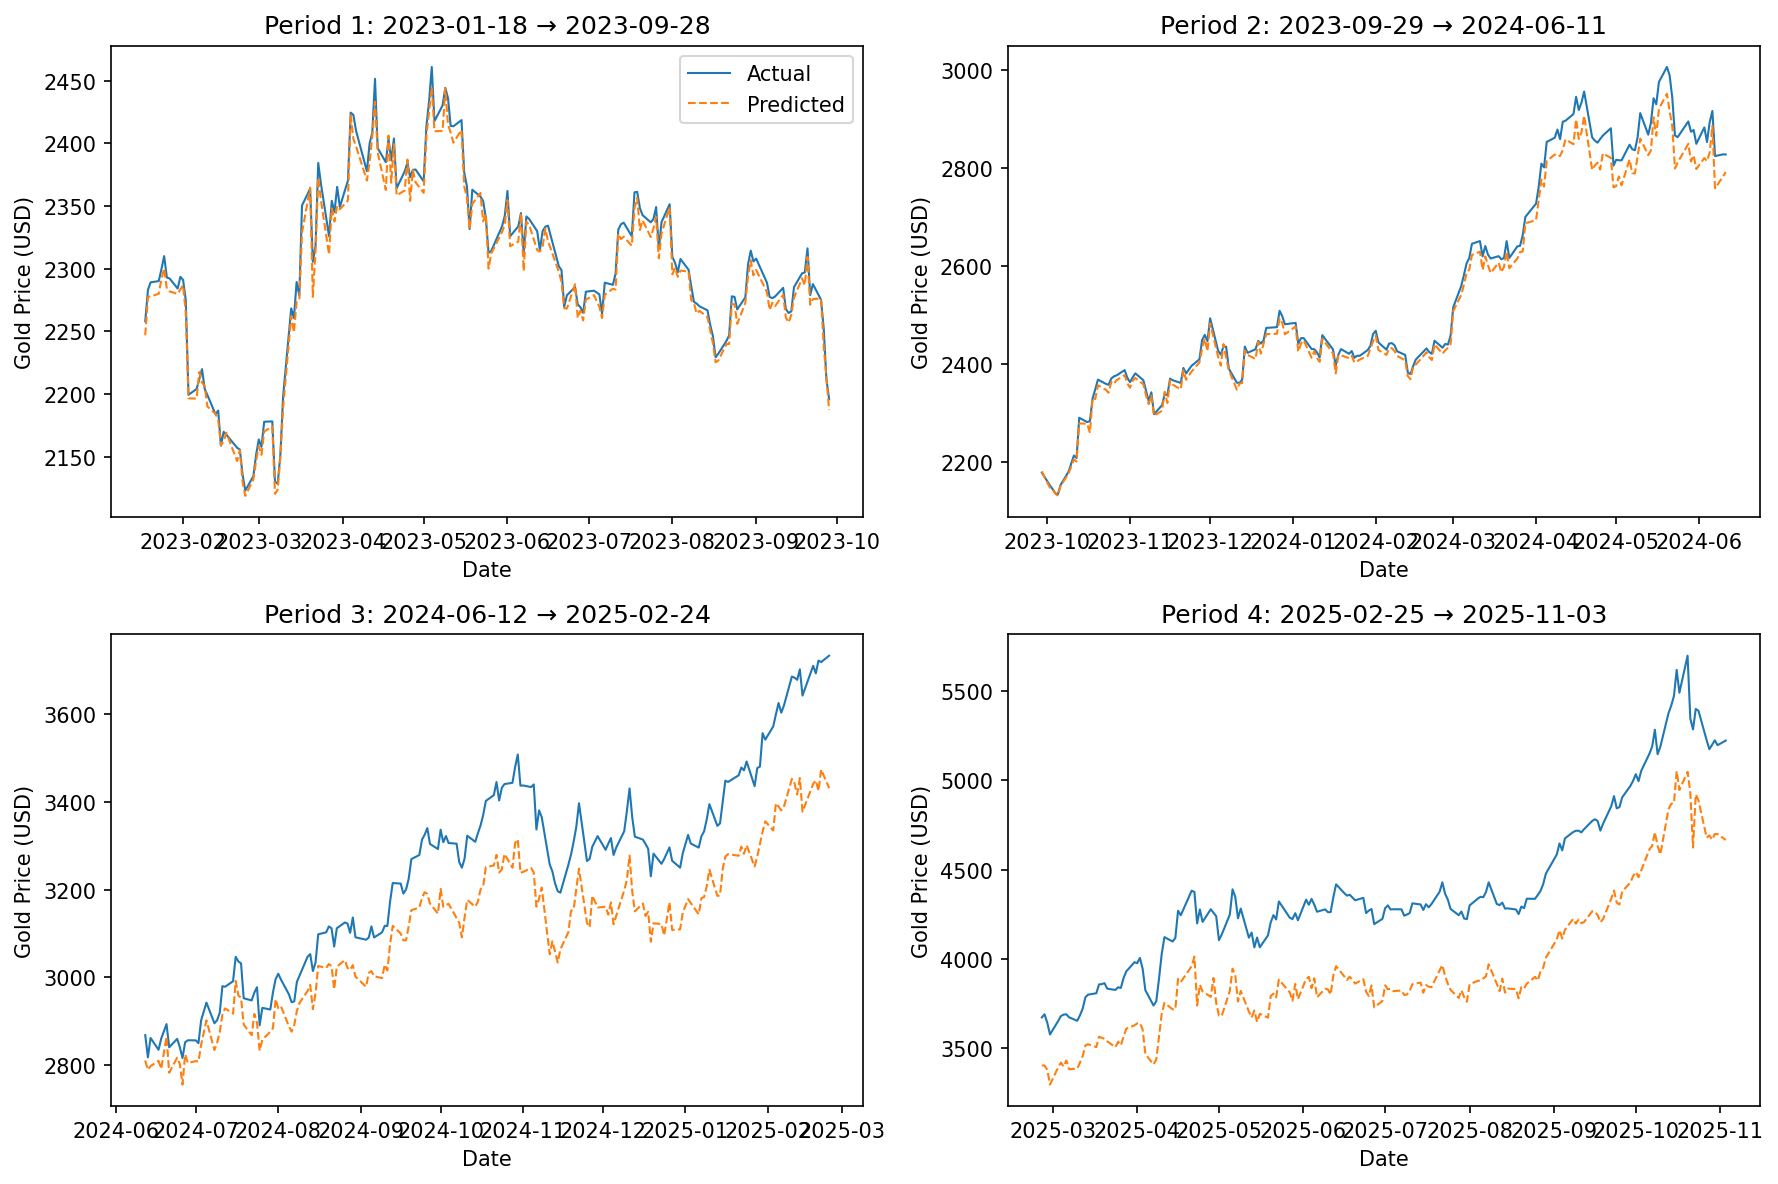

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates  = test_df.index[look_back:]


n_plots   = 4
N         = len(dates)
chunk     = N // n_plots


fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
axes     = axes.flatten()

for i, ax in enumerate(axes):
    start = i * chunk
    end   = (i + 1) * chunk if i < n_plots - 1 else N

    ax.plot(dates[start:end], y_true[start:end], label='Actual', linewidth=1)
    ax.plot(dates[start:end], y_pred[start:end], label='Predicted',
            linestyle='--', linewidth=1)

    ax.set_title(f'Period {i+1}: {dates[start].date()} → {dates[end-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()


#lookback = 5, wavelet = db1, level = 1

In [ ]:
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import yfinance as yf
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()


train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]


val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]
print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


scaler      = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])


if train_scaled.shape[0] % 2 != 0:
    train_scaled = train_scaled[:-1]
    train_df = train_df.iloc[:-1]
if val_scaled.shape[0] % 2 != 0:
    val_scaled = val_scaled[:-1]
    val_df = val_df.iloc[:-1]
if test_scaled.shape[0] % 2 != 0:
    test_scaled = test_scaled[:-1]
    test_df = test_df.iloc[:-1]


cA_train, cD_train = pywt.swt(train_scaled[:,0], 'db1', level=1)[0]
cA_val,   cD_val   = pywt.swt(val_scaled[:,0],   'db1', level=1)[0]
cA_test,  cD_test  = pywt.swt(test_scaled[:,0],  'db1', level=1)[0]


def make_sequences(data, look_back=5):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 5
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)

X_A_train = X_A_train.reshape(-1, look_back, 1)
X_A_val   = X_A_val.reshape(-1, look_back, 1)
X_A_test  = X_A_test.reshape(-1, look_back, 1)
X_D_train = X_D_train.reshape(-1, look_back, 1)
X_D_val   = X_D_val.reshape(-1, look_back, 1)
X_D_test  = X_D_test.reshape(-1, look_back, 1)

def build_lstm_model():
    m = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return m

model_A = build_lstm_model()
model_D = build_lstm_model()


history_A = model_A.fit(
    X_A_train, y_A_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_A_val, y_A_val),
    verbose=2
)
history_D = model_D.fit(
    X_D_train, y_D_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_D_val, y_D_val),
    verbose=2
)


pred_A = model_A.predict(X_A_test).flatten()
pred_D = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D

truetarget = y_A_test.reshape(-1,1) + y_D_test.reshape(-1,1)
combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(truetarget.reshape(-1,1))

/tmp/ipython-input-2810262584.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()
[*********************100%***********************]  1 of 1 completed

Rows → Train: 2779, Val: 490, Test: 715
Epoch 1/150



/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


28/28 - 2s - 85ms/step - loss: 40.5420 - val_loss: 3.7029
Epoch 2/150
28/28 - 0s - 13ms/step - loss: 12.8309 - val_loss: 11.3127
Epoch 3/150
28/28 - 0s - 12ms/step - loss: 8.9124 - val_loss: 5.3680
Epoch 4/150
28/28 - 0s - 14ms/step - loss: 8.1090 - val_loss: 2.9223
Epoch 5/150
28/28 - 0s - 13ms/step - loss: 7.8812 - val_loss: 2.4468
Epoch 6/150
28/28 - 0s - 13ms/step - loss: 7.5030 - val_loss: 2.4090
Epoch 7/150
28/28 - 0s - 13ms/step - loss: 7.1204 - val_loss: 2.5515
Epoch 8/150
28/28 - 1s - 20ms/step - loss: 7.3408 - val_loss: 2.7614
Epoch 9/150
28/28 - 1s - 22ms/step - loss: 7.0737 - val_loss: 2.6167
Epoch 10/150
28/28 - 1s - 22ms/step - loss: 6.9992 - val_loss: 3.0105
Epoch 11/150
28/28 - 1s - 37ms/step - loss: 7.6649 - val_loss: 2.9815
Epoch 12/150
28/28 - 0s - 14ms/step - loss: 7.3820 - val_loss: 2.3026
Epoch 13/150
28/28 - 0s - 13ms/step - loss: 7.3376 - val_loss: 2.4148
Epoch 14/150
28/28 - 0s - 13ms/step - loss: 6.8916 - val_loss: 3.2025
Epoch 15/150
28/28 - 0s - 12ms/step - 

Test MAPE: 2.17%


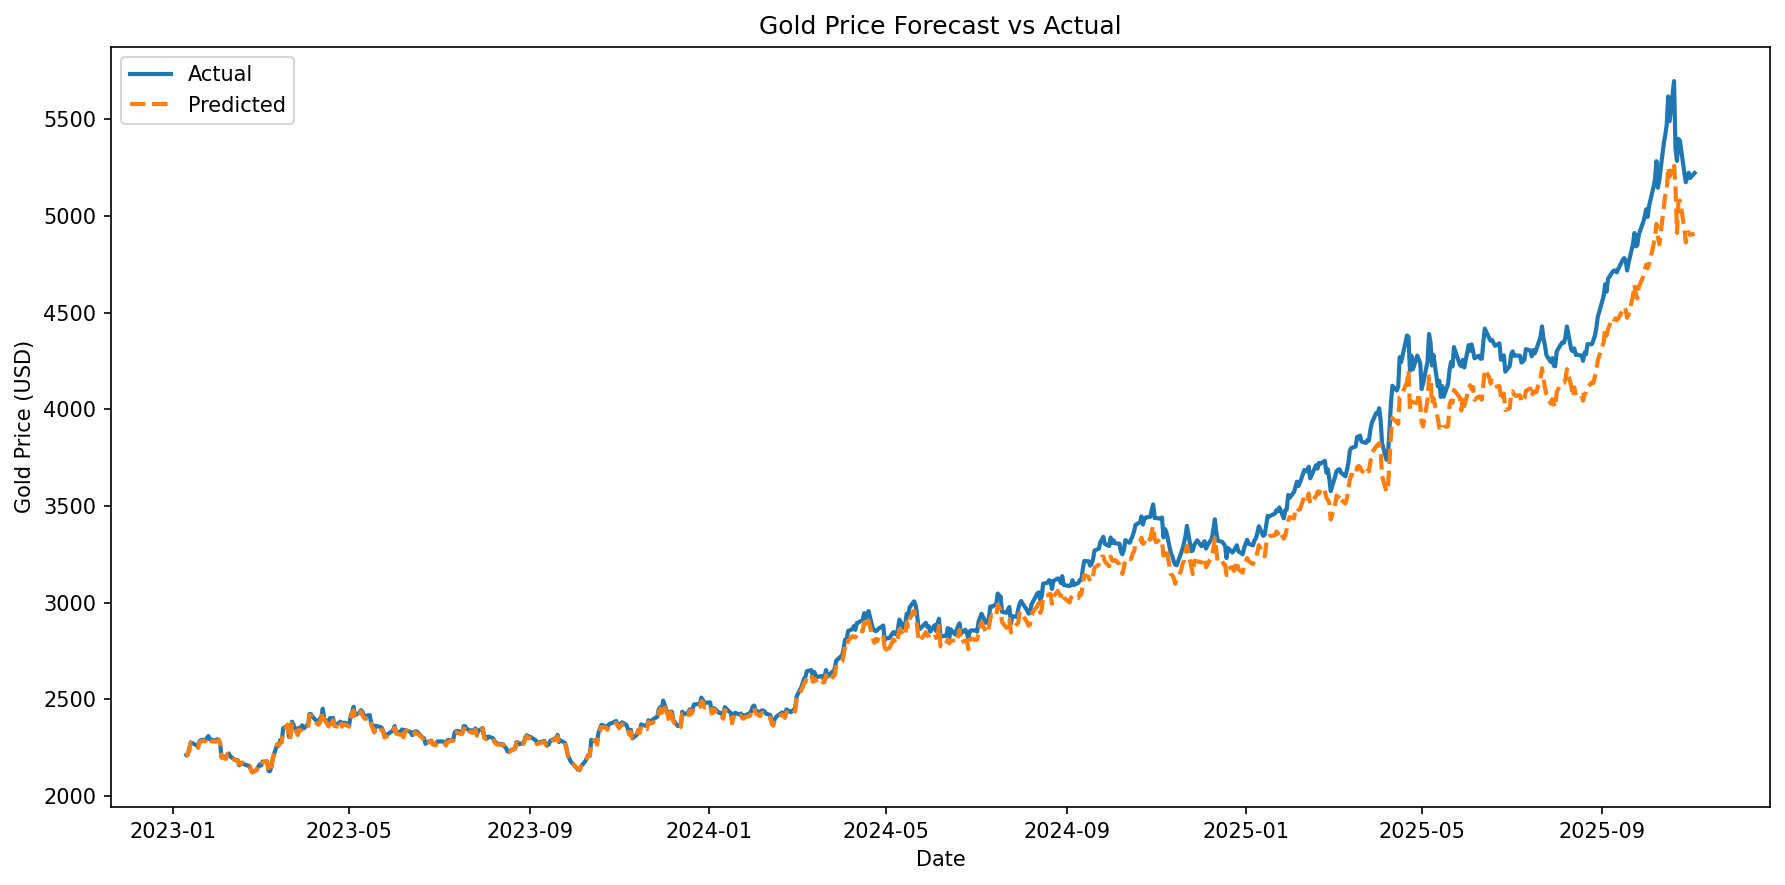

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)

n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")


RMSE: 120.83 USD
MAE:  83.19 USD
MAPE: 2.17%
RSE:  121.00 USD
R²:   0.9800


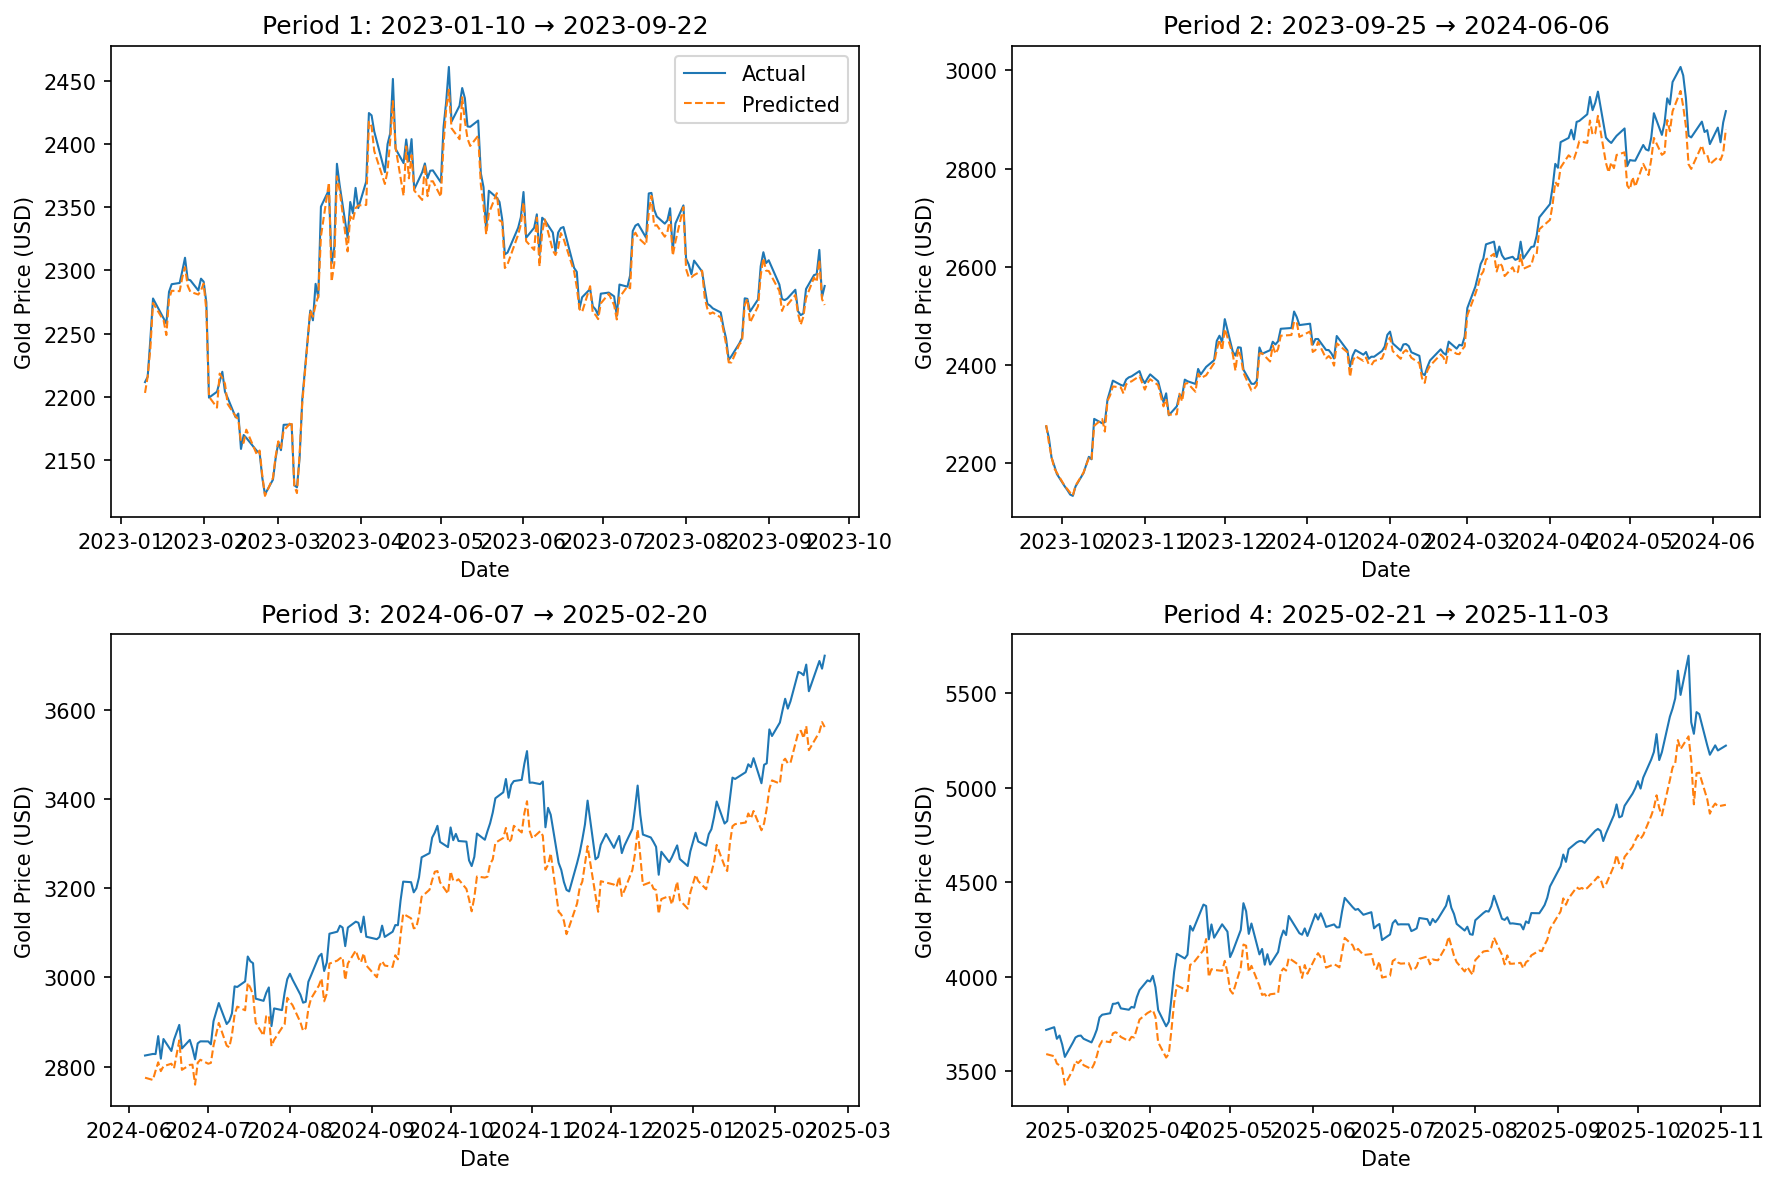

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates  = test_df.index[look_back:]

n_plots   = 4
N         = len(dates)
chunk     = N // n_plots

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
axes     = axes.flatten()

for i, ax in enumerate(axes):
    start = i * chunk
    end   = (i + 1) * chunk if i < n_plots - 1 else N

    ax.plot(dates[start:end], y_true[start:end], label='Actual', linewidth=1)
    ax.plot(dates[start:end], y_pred[start:end], label='Predicted',
            linestyle='--', linewidth=1)

    ax.set_title(f'Period {i+1}: {dates[start].date()} → {dates[end-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()


#lookback = 50, wavelet = db1, level = 1

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import yfinance as yf
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()


train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]


val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]

print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


scaler      = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])


if train_scaled.shape[0] % 2 != 0:
    train_scaled = train_scaled[:-1]
    train_df = train_df.iloc[:-1]
if val_scaled.shape[0] % 2 != 0:
    val_scaled = val_scaled[:-1]
    val_df = val_df.iloc[:-1]
if test_scaled.shape[0] % 2 != 0:
    test_scaled = test_scaled[:-1]
    test_df = test_df.iloc[:-1]



cA_train, cD_train = pywt.swt(train_scaled[:,0], 'db1', level=1)[0]
cA_val,   cD_val   = pywt.swt(val_scaled[:,0],   'db1', level=1)[0]
cA_test,  cD_test  = pywt.swt(test_scaled[:,0],  'db1', level=1)[0]


def make_sequences(data, look_back=50):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 50
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)


X_A_train = X_A_train.reshape(-1, look_back, 1)
X_A_val   = X_A_val.reshape(-1, look_back, 1)
X_A_test  = X_A_test.reshape(-1, look_back, 1)
X_D_train = X_D_train.reshape(-1, look_back, 1)
X_D_val   = X_D_val.reshape(-1, look_back, 1)
X_D_test  = X_D_test.reshape(-1, look_back, 1)


def build_lstm_model():
    m = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return m

model_A = build_lstm_model()
model_D = build_lstm_model()


history_A = model_A.fit(
    X_A_train, y_A_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_A_val, y_A_val),
    verbose=2
)
history_D = model_D.fit(
    X_D_train, y_D_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_D_val, y_D_val),
    verbose=2
)


pred_A = model_A.predict(X_A_test).flatten()
pred_D = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D
truetarget = y_A_test.reshape(-1,1) + y_D_test.reshape(-1,1)
combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(truetarget.reshape(-1,1))

/tmp/ipython-input-1139707670.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Rows → Train: 2779, Val: 490, Test: 715
Epoch 1/150
28/28 - 5s - 164ms/step - loss: 39.2930 - val_loss: 27.0369
Epoch 2/150
28/28 - 2s - 69ms/step - loss: 22.1017 - val_loss: 15.4682
Epoch 3/150
28/28 - 2s - 89ms/step - loss: 16.7157 - val_loss: 6.4286
Epoch 4/150
28/28 - 2s - 68ms/step - loss: 12.6741 - val_loss: 2.7164
Epoch 5/150
28/28 - 3s - 105ms/step - loss: 10.6142 - val_loss: 5.9709
Epoch 6/150
28/28 - 2s - 75ms/step - loss: 12.0625 - val_loss: 2.8421
Epoch 7/150
28/28 - 2s - 88ms/step - loss: 12.5741 - val_loss: 4.3108
Epoch 8/150
28/28 - 2s - 67ms/step - loss: 13.3124 - val_loss: 7.7534
Epoch 9/150
28/28 - 2s - 74ms/step - loss: 10.2030 - val_loss: 2.6690
Epoch 10/150
28/28 - 2s - 74ms/step - loss: 10.3300 - val_loss: 2.7979
Epoch 11/150
28/28 - 3s - 112ms/step - loss: 12.7028 - val_loss: 6.2405
Epoch 12/150
28/28 - 2s - 69ms/step - loss: 9.6774 - val_loss: 2.3925
Epoch 13/150
28/28 - 2s - 68ms/step - loss: 9.9275 - val_loss: 2.9549
Epoch 14/150
28/28 - 2s - 68ms/step - loss:

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()


rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)

n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates  = test_df.index[look_back:]

n_plots   = 4
N         = len(dates)
chunk     = N // n_plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
axes     = axes.flatten()
for i, ax in enumerate(axes):
    start = i * chunk
    end   = (i + 1) * chunk if i < n_plots - 1 else N

    ax.plot(dates[start:end], y_true[start:end], label='Actual', linewidth=1)
    ax.plot(dates[start:end], y_pred[start:end], label='Predicted',
            linestyle='--', linewidth=1)

    ax.set_title(f'Period {i+1}: {dates[start].date()} → {dates[end-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

#lookback = 1 , wavelet = db4, level = 2

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import yfinance as yf
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()


train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]


val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]

print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


scaler      = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])


if train_scaled.shape[0] % 2 != 0:
    train_scaled = train_scaled[:-1]
    train_df = train_df.iloc[:-1]
if val_scaled.shape[0] % 2 != 0:
    val_scaled = val_scaled[:-1]
    val_df = val_df.iloc[:-1]
if test_scaled.shape[0] % 2 != 0:
    test_scaled = test_scaled[:-1]
    test_df = test_df.iloc[:-1]



wavelet = 'db4'
level   = 2

div = 2**level

def trim_for_swt(arr, df_ref):
    """Trim the last few samples so len(arr) % div == 0."""
    rem = arr.shape[0] % div
    if rem:
        arr = arr[:-rem]

        df_ref.drop(df_ref.tail(rem).index, inplace=True)
    return arr


train_scaled = trim_for_swt(train_scaled, train_df)
val_scaled   = trim_for_swt(val_scaled,   val_df)
test_scaled  = trim_for_swt(test_scaled,  test_df)

print("Trimmed lengths →",
      len(train_scaled), len(val_scaled), len(test_scaled))


coeffs_train = pywt.swt(train_scaled[:,0], wavelet, level=level)
coeffs_val   = pywt.swt(val_scaled[:,0],   wavelet, level=level)
coeffs_test  = pywt.swt(test_scaled[:,0],  wavelet, level=level)

cA_train = coeffs_train[-1][0]
cA_val   = coeffs_val[-1][0]
cA_test  = coeffs_test[-1][0]

cD_train = coeffs_train[0][1] + coeffs_train[1][1]
cD_val   = coeffs_val[0][1]   + coeffs_val[1][1]
cD_test  = coeffs_test[0][1]  + coeffs_test[1][1]



def make_sequences(data, look_back=1):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 1
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)

X_A_train = X_A_train.reshape(-1, look_back, 1)
X_A_val   = X_A_val.reshape(-1, look_back, 1)
X_A_test  = X_A_test.reshape(-1, look_back, 1)
X_D_train = X_D_train.reshape(-1, look_back, 1)
X_D_val   = X_D_val.reshape(-1, look_back, 1)
X_D_test  = X_D_test.reshape(-1, look_back, 1)


def build_lstm_model():
    m = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return m

model_A = build_lstm_model()
model_D = build_lstm_model()


history_A = model_A.fit(
    X_A_train, y_A_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_A_val, y_A_val),
    verbose=2
)
history_D = model_D.fit(
    X_D_train, y_D_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_D_val, y_D_val),
    verbose=2
)


pred_A = model_A.predict(X_A_test).flatten()
pred_D = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D
truetarget = y_A_test.reshape(-1,1) + y_D_test.reshape(-1,1)
combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(truetarget.reshape(-1,1))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")


plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)
n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates  = test_df.index[look_back:]

n_plots   = 4
N         = len(dates)
chunk     = N // n_plots


fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
axes     = axes.flatten()

for i, ax in enumerate(axes):
    start = i * chunk
    end   = (i + 1) * chunk if i < n_plots - 1 else N

    ax.plot(dates[start:end], y_true[start:end], label='Actual', linewidth=1)
    ax.plot(dates[start:end], y_pred[start:end], label='Predicted',
            linestyle='--', linewidth=1)

    ax.set_title(f'Period {i+1}: {dates[start].date()} → {dates[end-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

#lookback = 1, wavelet = sym3, level = 2

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import pandas as pd
import pywt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import yfinance as yf
start_date = "2010-01-01"
end_date   = pd.Timestamp.today().strftime("%Y-%m-%d")
df = yf.download("GC=F", start=start_date, end=end_date)[["Close"]].dropna()


train_val_df = df.loc[:'2023-01-01']
test_df      = df.loc['2023-01-02':]


val_size   = int(0.15 * len(train_val_df))
train_df   = train_val_df.iloc[:-val_size]
val_df     = train_val_df.iloc[-val_size:]

print(f"Rows → Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


scaler      = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_df[['Close']])
val_scaled   = scaler.transform(val_df[['Close']])
test_scaled  = scaler.transform(test_df[['Close']])

if train_scaled.shape[0] % 2 != 0:
    train_scaled = train_scaled[:-1]
    train_df = train_df.iloc[:-1]
if val_scaled.shape[0] % 2 != 0:
    val_scaled = val_scaled[:-1]
    val_df = val_df.iloc[:-1]
if test_scaled.shape[0] % 2 != 0:
    test_scaled = test_scaled[:-1]
    test_df = test_df.iloc[:-1]


wavelet = 'sym3'
level   = 2
div     = 2**level

def trim_for_swt(arr, df_ref):
    rem = arr.shape[0] % div
    if rem:
        arr = arr[:-rem]
        df_ref.drop(df_ref.tail(rem).index, inplace=True)
    return arr

train_scaled = trim_for_swt(train_scaled, train_df)
val_scaled   = trim_for_swt(val_scaled,   val_df)
test_scaled  = trim_for_swt(test_scaled,  test_df)


coeffs_train = pywt.swt(train_scaled[:,0], wavelet, level=level)
coeffs_val   = pywt.swt(val_scaled[:,0],   wavelet, level=level)
coeffs_test  = pywt.swt(test_scaled[:,0],  wavelet, level=level)


cA_train = coeffs_train[-1][0]
cA_val   = coeffs_val[-1][0]
cA_test  = coeffs_test[-1][0]

cD_train = coeffs_train[0][1] + coeffs_train[1][1]
cD_val   = coeffs_val[0][1]   + coeffs_val[1][1]
cD_test  = coeffs_test[0][1]  + coeffs_test[1][1]

print("Decomposed with Symlet-3 @ level 2 →",
      "cA_train:", cA_train.shape,
      "cD_train:", cD_train.shape)

def make_sequences(data, look_back=1):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i])
        y.append(data[i])
    return np.array(X), np.array(y)

look_back = 1
X_A_train, y_A_train = make_sequences(cA_train.reshape(-1,1), look_back)
X_A_val,   y_A_val   = make_sequences(cA_val.reshape(-1,1),   look_back)
X_A_test,  y_A_test  = make_sequences(cA_test.reshape(-1,1),  look_back)

X_D_train, y_D_train = make_sequences(cD_train.reshape(-1,1), look_back)
X_D_val,   y_D_val   = make_sequences(cD_val.reshape(-1,1),   look_back)
X_D_test,  y_D_test  = make_sequences(cD_test.reshape(-1,1),  look_back)


X_A_train = X_A_train.reshape(-1, look_back, 1)
X_A_val   = X_A_val.reshape(-1, look_back, 1)
X_A_test  = X_A_test.reshape(-1, look_back, 1)
X_D_train = X_D_train.reshape(-1, look_back, 1)
X_D_val   = X_D_val.reshape(-1, look_back, 1)
X_D_test  = X_D_test.reshape(-1, look_back, 1)


def build_lstm_model():
    m = Sequential([
        LSTM(100, input_shape=(look_back, 1)),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    return m

model_A = build_lstm_model()
model_D = build_lstm_model()


history_A = model_A.fit(
    X_A_train, y_A_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_A_val, y_A_val),
    verbose=2
)
history_D = model_D.fit(
    X_D_train, y_D_train,
    epochs=150, batch_size=100,
    shuffle=False,
    validation_data=(X_D_val, y_D_val),
    verbose=2
)


pred_A = model_A.predict(X_A_test).flatten()
pred_D = model_D.predict(X_D_test).flatten()
combo_scaled = pred_A + pred_D

truetarget = y_A_test.reshape(-1,1) + y_D_test.reshape(-1,1)
combo_prices = scaler.inverse_transform(combo_scaled.reshape(-1,1))
true_prices  = scaler.inverse_transform(truetarget.reshape(-1,1))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error


y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates = test_df.index[look_back:]
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
print(f"Test MAPE: {mape:.2f}%")

plt.figure(figsize=(12,6), dpi=150)
plt.plot(dates, y_true, label='Actual', linewidth=2)
plt.plot(dates, y_pred, label='Predicted', linestyle='--', linewidth=2)
plt.title("Gold Price Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Gold Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred) * 100
r2   = r2_score(y_true, y_pred)
n   = len(y_true)
sse = np.sum((y_true - y_pred)**2)
rse = np.sqrt(sse / (n - 1 - 1))

print(f"RMSE: {rmse:.2f} USD")
print(f"MAE:  {mae:.2f} USD")
print(f"MAPE: {mape:.2f}%")
print(f"RSE:  {rse:.2f} USD")
print(f"R²:   {r2:.4f}")

y_true = true_prices.flatten()
y_pred = combo_prices.flatten()
dates  = test_df.index[look_back:]

n_plots   = 4
N         = len(dates)
chunk     = N // n_plots


fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=150)
axes     = axes.flatten()

for i, ax in enumerate(axes):
    start = i * chunk
    end   = (i + 1) * chunk if i < n_plots - 1 else N

    ax.plot(dates[start:end], y_true[start:end], label='Actual', linewidth=1)
    ax.plot(dates[start:end], y_pred[start:end], label='Predicted',
            linestyle='--', linewidth=1)

    ax.set_title(f'Period {i+1}: {dates[start].date()} → {dates[end-1].date()}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Gold Price (USD)')
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()